## Task-3: Variational Autoencoder (VAE)

Implement a VAE to learn latent representations of images, generate new samples, and analyze the effect of latent dimensionality

**Instructions:**

**Dataset:** Use MNIST, and preprocess      
**Model Implementation**:      
- Encoder: 3–4 Conv layers → flatten → Linear → output μ and log(σ²)
- Use latent dimension of 128
- Decoder: transpose convolutions → reconstruct image.  
    
**Training**            
- Loss: Reconstruction (MSE or BCE), KL divergence term
- Optimizer: Adam
- Train for 50 epochs.

- Visualize reconstruction and latent space evolution.
- Generation and Visualization: Sample random z vectors → generate images.
- Interpolate between two z vectors to observe smooth transitions.
- Change latent dimension to 256, retrain the model, and visualize generated images and reconstruction quality.

**Deliverable:**

- Jupyter notebook with clear code and comments.

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import os
from sklearn.manifold import TSNE
import time

In [21]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

BATCH_SIZE = 256

Using device: cuda


# Data loaders

In [22]:
trf = transforms.Compose([
  transforms.ToTensor(),
])

train_dataset = datasets.MNIST(root='.',
                                train=True,
                                transform=trf,
                                download=True)

test_dataset = datasets.MNIST(root='.',
                              train=False,
                              transform=trf)

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          num_workers=2,
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset,
                      batch_size=BATCH_SIZE,
                      num_workers=2,
                      shuffle=False)

https://ludovico-buizza.medium.com/generating-things-with-vaes-882c6e3b688d

Convolution:     
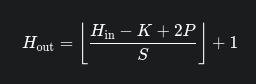

Transposed convolution:     
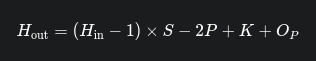

# VAE architecture

In [23]:
class Reshape(nn.Module):
    def __init__(self, *args):
        super().__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)


class Trim(nn.Module):
    def __init__(self, *args):
        super().__init__()

    def forward(self, x):
        return x[:, :, :28, :28]

In [ ]:
class VAE(nn.Module):
    def __init__(self, latent_dims=128): 
        super().__init__()

        # --- Encoder ---
        self.encoder = nn.Sequential(
                nn.Conv2d(1, 32, stride=2, kernel_size=3, bias=False, padding=1),
                nn.BatchNorm2d(32),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Dropout2d(0.25),
                nn.Conv2d(32, 64, stride=2, kernel_size=3, bias=False, padding=1),
                nn.BatchNorm2d(64),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Dropout2d(0.25),
                nn.Conv2d(64, 64, stride=1, kernel_size=3, bias=False, padding=1),
                nn.BatchNorm2d(64),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Flatten(), # Output size: 7x7x64 = 3136
        )

        self.z_mean = torch.nn.Linear(3136, latent_dims)
        self.z_log_var = torch.nn.Linear(3136, latent_dims)

        # --- Decoder ---
        self.decoder = nn.Sequential(
                torch.nn.Linear(latent_dims, 3136), 
                Reshape(-1, 64, 7, 7),
                nn.ConvTranspose2d(64, 64, stride=2, kernel_size=3),
                nn.BatchNorm2d(64),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Dropout2d(0.25),
                nn.ConvTranspose2d(64, 64, stride=2, kernel_size=3, padding=1),
                nn.BatchNorm2d(64),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Dropout2d(0.25),
                nn.ConvTranspose2d(64, 32, stride=2, kernel_size=3, padding=1),
                nn.BatchNorm2d(32),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Dropout2d(0.25),
                nn.ConvTranspose2d(32, 1, stride=2, kernel_size=3, padding=1),
                Trim(),  
                nn.Sigmoid()
                )

    def reparameterize(self, z_mu, z_log_var):
        eps = torch.randn(z_mu.size(0), z_mu.size(1)).to(z_mu.device) 
        z = z_mu + eps * torch.exp(z_log_var/2.)
        return z

    def encoding_fn(self, x):
        x = self.encoder(x)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        encoded = self.reparameterize(z_mean, z_log_var)
        return encoded

    def forward(self, x):
        x = self.encoder(x)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        encoded = self.reparameterize(z_mean, z_log_var)
        decoded = self.decoder(encoded)
        return encoded, z_mean, z_log_var, decoded

# Training loop and visualization functions

In [25]:
def compute_epoch_loss_autoencoder(model, data_loader, loss_fn, device):
    model.eval()
    curr_loss, num_examples = 0., 0
    with torch.no_grad():
        for features, _ in data_loader:
            features = features.to(device)
            _, _, _, logits = model(features)
            loss = loss_fn(logits, features, reduction='sum')
            num_examples += features.size(0)
            curr_loss += loss

        curr_loss = curr_loss / num_examples
        return curr_loss

In [ ]:
def train_vae(model, optimizer, loss_fn, train_loader, NUM_EPOCHS, device, 
              logging_interval, compute_epoch_loss_autoencoder, skip_epoch_stats=False, save_dir=None):
    
    log_dict = {'train_combined_loss_per_batch': [],
                'train_combined_loss_per_epoch': [],
                'train_reconstruction_loss_per_batch': [],
                'train_kl_loss_per_batch': []}
    
    start_time = time.time()

    epochs_to_save = [1, 10, 30, 50] 
    
    for epoch in range(NUM_EPOCHS):
        model.train()
        
        iterator = train_loader
        try:
            iterator = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} (Train)")
        except NameError: 
            pass
            
        for batch_idx, (features, _) in enumerate(iterator):
            features = features.to(device)

            # FORWARD AND BACK PROP
            encoded, z_mean, z_log_var, decoded = model(features)

            # KL divergence 
            kl_div = -0.5 * torch.sum(1 + z_log_var - z_mean**2 - torch.exp(z_log_var), axis=1) 
            batchsize = kl_div.size(0)
            kl_div = kl_div.mean() 

            pixelwise = loss_fn(decoded, features, reduction='none')
            pixelwise = pixelwise.view(batchsize, -1).sum(axis=1) 
            pixelwise = pixelwise.mean() 

            loss = pixelwise + kl_div

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            log_dict['train_combined_loss_per_batch'].append(loss.item())
            log_dict['train_reconstruction_loss_per_batch'].append(pixelwise.item())
            log_dict['train_kl_loss_per_batch'].append(kl_div.item())

            if not batch_idx % logging_interval:
                print('Epoch: %03d/%03d | Batch %04d/%04d | Loss: %.4f'
                      % (epoch+1, NUM_EPOCHS, batch_idx,
                         len(train_loader), loss.item()))

        if not skip_epoch_stats:
            model.eval()
            with torch.set_grad_enabled(False): 
                train_loss = compute_epoch_loss_autoencoder(
                    model, train_loader, loss_fn, device)
                print('***Epoch: %03d/%03d | Loss: %.3f' % (
                        epoch+1, NUM_EPOCHS, train_loss.item()))
                log_dict['train_combined_loss_per_epoch'].append(train_loss.item())
            
            if save_dir and (epoch + 1) in epochs_to_save:
                os.makedirs(save_dir, exist_ok=True)
                weights_path = os.path.join(save_dir, f"vae_weights_epoch_{epoch+1}.pth")
                torch.save(model.state_dict(), weights_path)


        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))
    
    return model, log_dict

In [ ]:
def plot_training_loss(minibatch_losses, num_epochs, averaging_iterations=100, custom_label=''):

    iter_per_epoch = len(minibatch_losses) // num_epochs

    plt.figure()
    ax1 = plt.subplot(1, 1, 1)
    ax1.plot(range(len(minibatch_losses)),
             (minibatch_losses), label=f'Minibatch Loss{custom_label}')
    ax1.set_xlabel('Iterations')
    ax1.set_ylabel('Loss')

    if len(minibatch_losses) < 1000:
        num_losses = len(minibatch_losses) // 2
    else:
        num_losses = 1000

    ax1.set_ylim([
        0, np.max(minibatch_losses[num_losses:])*1.5
        ])

    ax1.plot(np.convolve(minibatch_losses,
                         np.ones(averaging_iterations,)/averaging_iterations,
                         mode='valid'),
             label=f'Running Average{custom_label}')
    ax1.legend()

    # Set scond x-axis
    ax2 = ax1.twiny()
    newlabel = list(range(num_epochs+1))

    newpos = [e*iter_per_epoch for e in newlabel]

    ax2.set_xticks(newpos[::10])
    ax2.set_xticklabels(newlabel[::10])

    ax2.xaxis.set_ticks_position('bottom')
    ax2.xaxis.set_label_position('bottom')
    ax2.spines['bottom'].set_position(('outward', 45))
    ax2.set_xlabel('Epochs')
    ax2.set_xlim(ax1.get_xlim())

    plt.tight_layout()

In [ ]:
def visualize_reconstruction(model, loader, device):
    model.eval()

    num_classes = 10
    selected_images = []
    found_labels = set()
    data_iterator = iter(loader)
    
    while len(found_labels) < num_classes:
        try:
            x_batch, y_batch = next(data_iterator)
        except StopIteration:
            print("Warning: Dataset exhausted before finding all 10 classes.")
            break

        for i in range(len(y_batch)):
            label = y_batch[i].item()
            if label not in found_labels:
                selected_images.append((x_batch[i], label))
                found_labels.add(label)
        
        selected_images.sort(key=lambda item: item[1])
        selected_images = selected_images[:num_classes]
    
    if not selected_images:
        print("Error: Could not find any images.")
        return
        
    x_display = torch.stack([img for img, label in selected_images]).to(device)
    labels_display = [label for img, label in selected_images]

    with torch.no_grad():
        _, _, _, reconstruction = model(x_display) 
    
    fig, axes = plt.subplots(2, num_classes, figsize=(18, 4))
 
    for i in range(num_classes):
        axes[0, i].imshow(x_display[i].cpu().squeeze(), cmap='gray')
        axes[0, i].set_title(f"Class {labels_display[i]}", fontsize=12)
        axes[0, i].axis('off')
        
        axes[1, i].imshow(reconstruction[i].cpu().squeeze(), cmap='gray')
        axes[1, i].axis('off')

        if i == 0:
            axes[0, i].set_ylabel("Original", fontsize=12, rotation=0, ha='right', labelpad=20)
            axes[1, i].set_ylabel("Reconstruction", fontsize=12, rotation=0, ha='right', labelpad=20)
        
    plt.tight_layout()
    plt.show()

def visualize_latent_structure_evolution(model_class, latent_dims, loader, device, epochs_to_show, weights_dir='./vae_snapshots'):
    num_plots = len(epochs_to_show)
    fig, axes = plt.subplots(1, num_plots, figsize=(4 * num_plots, 4))
    if num_plots == 1: axes = [axes] 

    model_instance = model_class(latent_dims=latent_dims)
    model_instance.to(device)
    model_instance.eval()
    
    print(f"\nGenerating t-SNE evolution for epochs: {epochs_to_show}...")

    for i, epoch in enumerate(tqdm(epochs_to_show, desc="Processing t-SNE snapshots")):
        weights_path = os.path.join(weights_dir, f"vae_weights_epoch_{epoch}.pth")
        
        try:
            if not os.path.exists(weights_path):
                print(f"\nSkipping epoch {epoch}: Weights file not found at {weights_path}.")
                continue
                
            model_instance.load_state_dict(torch.load(weights_path, map_location=device))
            
        except Exception as e:
            print(f"\nError loading weights for epoch {epoch}: {e}")
            continue
        
        zs, labels = [], []
        
        # Collecting data only for a few batches
        with torch.no_grad():
            for batch_idx, (x, y) in enumerate(loader):
                x = x.to(device)
                
                _, mu, _, _ = model_instance(x) 
                
                zs.append(mu.cpu().numpy()) 
                labels.append(y.numpy())
                if batch_idx >= 50: 
                    break

        zs = np.concatenate(zs)
        labels = np.concatenate(labels)
        
        z_2d = TSNE(n_components=2, random_state=2, init='pca', learning_rate='auto').fit_transform(zs)
      
        ax = axes[i]
        scatter = ax.scatter(z_2d[:,0], z_2d[:,1], c=labels, cmap='tab10', s=5, alpha=0.8)
        ax.set_title(f"Epoch {epoch}", fontsize=12)
        ax.axis('off')
        
        if i == num_plots - 1:
            plt.colorbar(scatter, ax=axes.tolist(), ticks=range(10), label='Digit Class')
            
    plt.show()

def generate_samples(model, latent_dims, device, num_samples=10):
    
    model.eval()
    # random Z
    z = torch.randn(num_samples, latent_dims).to(device)
    
    with torch.no_grad():
        generated_images = model.decoder(z) 
        
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 1.5))
    for i in range(num_samples):
        axes[i].imshow(generated_images[i].cpu().squeeze(), cmap='gray')
        axes[i].axis('off')
    plt.suptitle("Generated Samples from Random Z", fontsize=16)
    plt.show()


def interpolate_samples(model, latent_dims, device, num_steps=10, mode='spherical'):
    model.eval()
    
    # 2 random Z vectors
    z1 = torch.randn(1, latent_dims).to(device)
    z2 = torch.randn(1, latent_dims).to(device)
    
    interpolated_images = []

    def slerp(z1, z2, alpha):
        """Spherical Linear Interpolation"""
        z1_norm = z1 / torch.norm(z1, dim=1, keepdim=True)
        z2_norm = z2 / torch.norm(z2, dim=1, keepdim=True)
        dot = (z1_norm * z2_norm).sum(dim=1, keepdim=True)
        dot = torch.clamp(dot, -1.0, 1.0)
        theta = torch.acos(dot)
        sin_theta = torch.sin(theta)

        if torch.any(sin_theta < 1e-6):
            return (1 - alpha) * z1 + alpha * z2
        return (torch.sin((1 - alpha) * theta) / sin_theta) * z1 + (torch.sin(alpha * theta) / sin_theta) * z2
    
    for i in range(num_steps):
        alpha = i / (num_steps - 1)
        if mode == 'spherical':
            z_interp = slerp(z1, z2, alpha)
        else:
            z_interp = z1 * (1 - alpha) + z2 * alpha
        
        with torch.no_grad():
            img = model.decoder(z_interp)
            interpolated_images.append(img.squeeze().cpu().numpy())
            
    fig, axes = plt.subplots(1, num_steps, figsize=(15, 1.5))
    for i in range(num_steps):
        axes[i].imshow(interpolated_images[i], cmap='gray')
        axes[i].axis('off')
        
    plt.suptitle("Latent Space Interpolation (Smooth Transitions)", fontsize=16)
    plt.show()

Linear interpolation   
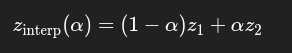

Spherical interpolation   
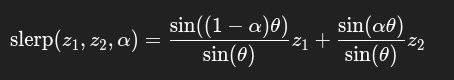

# VAE training: latent dimensions = 128

In [ ]:
LATENT_DIM = 128
EPOCHS = 50
LR = 2e-4
LOGGING_INTERVAL = 50 

loss_fn = F.mse_loss
model = VAE(latent_dims=LATENT_DIM).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LR)
print(f"Starting VAE training with Latent Dims: {LATENT_DIM}")

SAVE_DIR = "vae_snapchots_d128"

trained_model_128, history_128d = train_vae(
    model=model,
    optimizer=optimizer,
    loss_fn=loss_fn,
    train_loader=train_loader, 
    NUM_EPOCHS=EPOCHS,
    device=DEVICE,
    logging_interval=LOGGING_INTERVAL,
    compute_epoch_loss_autoencoder=compute_epoch_loss_autoencoder, 
    skip_epoch_stats=False,
    save_dir=SAVE_DIR
)

Starting VAE training with Latent Dims: 128


Epoch 1/50 (Train):   0%|          | 1/235 [00:00<00:29,  7.87it/s]

Epoch: 001/050 | Batch 0000/0235 | Loss: 229.7535


Epoch 1/50 (Train):  24%|██▍       | 57/235 [00:01<00:05, 32.55it/s]

Epoch: 001/050 | Batch 0050/0235 | Loss: 80.9573


Epoch 1/50 (Train):  45%|████▍     | 105/235 [00:03<00:04, 32.47it/s]

Epoch: 001/050 | Batch 0100/0235 | Loss: 70.6221


Epoch 1/50 (Train):  67%|██████▋   | 157/235 [00:04<00:02, 32.55it/s]

Epoch: 001/050 | Batch 0150/0235 | Loss: 64.2468


Epoch 1/50 (Train):  87%|████████▋ | 205/235 [00:06<00:00, 32.80it/s]

Epoch: 001/050 | Batch 0200/0235 | Loss: 57.9059


Epoch 1/50 (Train): 100%|██████████| 235/235 [00:07<00:00, 32.10it/s]


***Epoch: 001/050 | Loss: 46.956
Time elapsed: 0.17 min


Epoch 2/50 (Train):   0%|          | 1/235 [00:00<00:29,  7.92it/s]

Epoch: 002/050 | Batch 0000/0235 | Loss: 55.1595


Epoch 2/50 (Train):  24%|██▍       | 57/235 [00:01<00:05, 32.42it/s]

Epoch: 002/050 | Batch 0050/0235 | Loss: 55.5652


Epoch 2/50 (Train):  45%|████▍     | 105/235 [00:03<00:03, 32.70it/s]

Epoch: 002/050 | Batch 0100/0235 | Loss: 53.5978


Epoch 2/50 (Train):  67%|██████▋   | 157/235 [00:04<00:02, 32.63it/s]

Epoch: 002/050 | Batch 0150/0235 | Loss: 50.6741


Epoch 2/50 (Train):  87%|████████▋ | 205/235 [00:06<00:00, 32.63it/s]

Epoch: 002/050 | Batch 0200/0235 | Loss: 50.6028


Epoch 2/50 (Train): 100%|██████████| 235/235 [00:07<00:00, 32.07it/s]


***Epoch: 002/050 | Loss: 40.586
Time elapsed: 0.33 min


Epoch 3/50 (Train):   0%|          | 1/235 [00:00<00:28,  8.33it/s]

Epoch: 003/050 | Batch 0000/0235 | Loss: 50.0236


Epoch 3/50 (Train):  24%|██▍       | 57/235 [00:01<00:05, 32.58it/s]

Epoch: 003/050 | Batch 0050/0235 | Loss: 51.3150


Epoch 3/50 (Train):  45%|████▍     | 105/235 [00:03<00:03, 32.70it/s]

Epoch: 003/050 | Batch 0100/0235 | Loss: 46.5717


Epoch 3/50 (Train):  67%|██████▋   | 157/235 [00:04<00:02, 32.43it/s]

Epoch: 003/050 | Batch 0150/0235 | Loss: 46.9304


Epoch 3/50 (Train):  87%|████████▋ | 205/235 [00:06<00:00, 32.36it/s]

Epoch: 003/050 | Batch 0200/0235 | Loss: 46.4735


Epoch 3/50 (Train): 100%|██████████| 235/235 [00:07<00:00, 32.04it/s]


***Epoch: 003/050 | Loss: 35.859
Time elapsed: 0.50 min


Epoch 4/50 (Train):   0%|          | 1/235 [00:00<00:28,  8.22it/s]

Epoch: 004/050 | Batch 0000/0235 | Loss: 47.1050


Epoch 4/50 (Train):  24%|██▍       | 57/235 [00:01<00:05, 32.12it/s]

Epoch: 004/050 | Batch 0050/0235 | Loss: 45.1859


Epoch 4/50 (Train):  45%|████▍     | 105/235 [00:03<00:04, 32.18it/s]

Epoch: 004/050 | Batch 0100/0235 | Loss: 44.4102


Epoch 4/50 (Train):  67%|██████▋   | 157/235 [00:04<00:02, 32.50it/s]

Epoch: 004/050 | Batch 0150/0235 | Loss: 44.7500


Epoch 4/50 (Train):  87%|████████▋ | 205/235 [00:06<00:00, 32.62it/s]

Epoch: 004/050 | Batch 0200/0235 | Loss: 43.7292


Epoch 4/50 (Train): 100%|██████████| 235/235 [00:07<00:00, 31.91it/s]


***Epoch: 004/050 | Loss: 32.889
Time elapsed: 0.66 min


Epoch 5/50 (Train):   0%|          | 1/235 [00:00<00:27,  8.41it/s]

Epoch: 005/050 | Batch 0000/0235 | Loss: 42.9004


Epoch 5/50 (Train):  24%|██▍       | 57/235 [00:01<00:05, 32.67it/s]

Epoch: 005/050 | Batch 0050/0235 | Loss: 42.6064


Epoch 5/50 (Train):  45%|████▍     | 105/235 [00:03<00:03, 32.70it/s]

Epoch: 005/050 | Batch 0100/0235 | Loss: 42.6646


Epoch 5/50 (Train):  67%|██████▋   | 157/235 [00:04<00:02, 32.56it/s]

Epoch: 005/050 | Batch 0150/0235 | Loss: 41.9518


Epoch 5/50 (Train):  87%|████████▋ | 205/235 [00:06<00:00, 32.46it/s]

Epoch: 005/050 | Batch 0200/0235 | Loss: 41.0117


Epoch 5/50 (Train): 100%|██████████| 235/235 [00:07<00:00, 32.15it/s]


***Epoch: 005/050 | Loss: 29.722
Time elapsed: 0.83 min


Epoch 6/50 (Train):   0%|          | 1/235 [00:00<00:28,  8.21it/s]

Epoch: 006/050 | Batch 0000/0235 | Loss: 41.1699


Epoch 6/50 (Train):  24%|██▍       | 57/235 [00:01<00:05, 32.54it/s]

Epoch: 006/050 | Batch 0050/0235 | Loss: 39.1166


Epoch 6/50 (Train):  45%|████▍     | 105/235 [00:03<00:03, 32.62it/s]

Epoch: 006/050 | Batch 0100/0235 | Loss: 41.0137


Epoch 6/50 (Train):  67%|██████▋   | 157/235 [00:04<00:02, 32.57it/s]

Epoch: 006/050 | Batch 0150/0235 | Loss: 40.1048


Epoch 6/50 (Train):  87%|████████▋ | 205/235 [00:06<00:00, 32.61it/s]

Epoch: 006/050 | Batch 0200/0235 | Loss: 40.0103


Epoch 6/50 (Train): 100%|██████████| 235/235 [00:07<00:00, 32.12it/s]


***Epoch: 006/050 | Loss: 27.173
Time elapsed: 0.99 min


Epoch 7/50 (Train):   0%|          | 1/235 [00:00<00:27,  8.49it/s]

Epoch: 007/050 | Batch 0000/0235 | Loss: 39.5015


Epoch 7/50 (Train):  24%|██▍       | 57/235 [00:01<00:05, 32.41it/s]

Epoch: 007/050 | Batch 0050/0235 | Loss: 37.6046


Epoch 7/50 (Train):  45%|████▍     | 105/235 [00:03<00:03, 32.65it/s]

Epoch: 007/050 | Batch 0100/0235 | Loss: 38.8236


Epoch 7/50 (Train):  67%|██████▋   | 157/235 [00:04<00:02, 32.63it/s]

Epoch: 007/050 | Batch 0150/0235 | Loss: 39.1266


Epoch 7/50 (Train):  87%|████████▋ | 205/235 [00:06<00:00, 32.56it/s]

Epoch: 007/050 | Batch 0200/0235 | Loss: 39.0133


Epoch 7/50 (Train): 100%|██████████| 235/235 [00:07<00:00, 32.12it/s]


***Epoch: 007/050 | Loss: 25.507
Time elapsed: 1.15 min


Epoch 8/50 (Train):   0%|          | 1/235 [00:00<00:27,  8.43it/s]

Epoch: 008/050 | Batch 0000/0235 | Loss: 38.0448


Epoch 8/50 (Train):  24%|██▍       | 57/235 [00:01<00:05, 32.61it/s]

Epoch: 008/050 | Batch 0050/0235 | Loss: 37.9662


Epoch 8/50 (Train):  45%|████▍     | 105/235 [00:03<00:03, 32.59it/s]

Epoch: 008/050 | Batch 0100/0235 | Loss: 37.0548


Epoch 8/50 (Train):  67%|██████▋   | 157/235 [00:04<00:02, 32.67it/s]

Epoch: 008/050 | Batch 0150/0235 | Loss: 37.3535


Epoch 8/50 (Train):  87%|████████▋ | 205/235 [00:06<00:00, 32.50it/s]

Epoch: 008/050 | Batch 0200/0235 | Loss: 37.4725


Epoch 8/50 (Train): 100%|██████████| 235/235 [00:07<00:00, 32.14it/s]


***Epoch: 008/050 | Loss: 23.995
Time elapsed: 1.32 min


Epoch 9/50 (Train):   0%|          | 1/235 [00:00<00:27,  8.43it/s]

Epoch: 009/050 | Batch 0000/0235 | Loss: 35.7126


Epoch 9/50 (Train):  24%|██▍       | 57/235 [00:01<00:05, 32.51it/s]

Epoch: 009/050 | Batch 0050/0235 | Loss: 36.5607


Epoch 9/50 (Train):  45%|████▍     | 105/235 [00:03<00:03, 32.61it/s]

Epoch: 009/050 | Batch 0100/0235 | Loss: 36.7527


Epoch 9/50 (Train):  67%|██████▋   | 157/235 [00:04<00:02, 32.72it/s]

Epoch: 009/050 | Batch 0150/0235 | Loss: 36.7210


Epoch 9/50 (Train):  87%|████████▋ | 205/235 [00:06<00:00, 32.71it/s]

Epoch: 009/050 | Batch 0200/0235 | Loss: 37.1247


Epoch 9/50 (Train): 100%|██████████| 235/235 [00:07<00:00, 32.18it/s]


***Epoch: 009/050 | Loss: 23.567
Time elapsed: 1.48 min


Epoch 10/50 (Train):   0%|          | 1/235 [00:00<00:28,  8.24it/s]

Epoch: 010/050 | Batch 0000/0235 | Loss: 36.9930


Epoch 10/50 (Train):  24%|██▍       | 57/235 [00:01<00:05, 32.55it/s]

Epoch: 010/050 | Batch 0050/0235 | Loss: 35.9060


Epoch 10/50 (Train):  45%|████▍     | 105/235 [00:03<00:03, 32.57it/s]

Epoch: 010/050 | Batch 0100/0235 | Loss: 37.3238


Epoch 10/50 (Train):  67%|██████▋   | 157/235 [00:04<00:02, 32.58it/s]

Epoch: 010/050 | Batch 0150/0235 | Loss: 35.6187


Epoch 10/50 (Train):  87%|████████▋ | 205/235 [00:06<00:00, 32.59it/s]

Epoch: 010/050 | Batch 0200/0235 | Loss: 36.3046


Epoch 10/50 (Train): 100%|██████████| 235/235 [00:07<00:00, 32.07it/s]


***Epoch: 010/050 | Loss: 22.552
Time elapsed: 1.65 min


Epoch 11/50 (Train):   0%|          | 1/235 [00:00<00:30,  7.71it/s]

Epoch: 011/050 | Batch 0000/0235 | Loss: 36.3675


Epoch 11/50 (Train):  24%|██▍       | 57/235 [00:01<00:05, 32.57it/s]

Epoch: 011/050 | Batch 0050/0235 | Loss: 35.5338


Epoch 11/50 (Train):  45%|████▍     | 105/235 [00:03<00:03, 32.70it/s]

Epoch: 011/050 | Batch 0100/0235 | Loss: 34.5619


Epoch 11/50 (Train):  67%|██████▋   | 157/235 [00:04<00:02, 32.67it/s]

Epoch: 011/050 | Batch 0150/0235 | Loss: 34.7500


Epoch 11/50 (Train):  87%|████████▋ | 205/235 [00:06<00:00, 32.52it/s]

Epoch: 011/050 | Batch 0200/0235 | Loss: 35.7175


Epoch 11/50 (Train): 100%|██████████| 235/235 [00:07<00:00, 32.08it/s]


***Epoch: 011/050 | Loss: 22.165
Time elapsed: 1.81 min


Epoch 12/50 (Train):   0%|          | 1/235 [00:00<00:27,  8.38it/s]

Epoch: 012/050 | Batch 0000/0235 | Loss: 35.1959


Epoch 12/50 (Train):  24%|██▍       | 57/235 [00:01<00:05, 32.39it/s]

Epoch: 012/050 | Batch 0050/0235 | Loss: 35.4148


Epoch 12/50 (Train):  45%|████▍     | 105/235 [00:03<00:04, 32.39it/s]

Epoch: 012/050 | Batch 0100/0235 | Loss: 34.7325


Epoch 12/50 (Train):  67%|██████▋   | 157/235 [00:04<00:02, 32.39it/s]

Epoch: 012/050 | Batch 0150/0235 | Loss: 35.1732


Epoch 12/50 (Train):  87%|████████▋ | 205/235 [00:06<00:00, 32.43it/s]

Epoch: 012/050 | Batch 0200/0235 | Loss: 34.9415


Epoch 12/50 (Train): 100%|██████████| 235/235 [00:07<00:00, 31.92it/s]


***Epoch: 012/050 | Loss: 21.982
Time elapsed: 1.98 min


Epoch 13/50 (Train):   0%|          | 1/235 [00:00<00:28,  8.31it/s]

Epoch: 013/050 | Batch 0000/0235 | Loss: 34.9695


Epoch 13/50 (Train):  24%|██▍       | 57/235 [00:01<00:05, 32.46it/s]

Epoch: 013/050 | Batch 0050/0235 | Loss: 34.3583


Epoch 13/50 (Train):  45%|████▍     | 105/235 [00:03<00:03, 32.52it/s]

Epoch: 013/050 | Batch 0100/0235 | Loss: 34.5736


Epoch 13/50 (Train):  67%|██████▋   | 157/235 [00:04<00:02, 32.55it/s]

Epoch: 013/050 | Batch 0150/0235 | Loss: 34.3927


Epoch 13/50 (Train):  87%|████████▋ | 205/235 [00:06<00:00, 32.54it/s]

Epoch: 013/050 | Batch 0200/0235 | Loss: 34.0465


Epoch 13/50 (Train): 100%|██████████| 235/235 [00:07<00:00, 32.05it/s]


***Epoch: 013/050 | Loss: 21.659
Time elapsed: 2.14 min


Epoch 14/50 (Train):   0%|          | 1/235 [00:00<00:32,  7.22it/s]

Epoch: 014/050 | Batch 0000/0235 | Loss: 34.0068


Epoch 14/50 (Train):  24%|██▍       | 57/235 [00:01<00:05, 32.22it/s]

Epoch: 014/050 | Batch 0050/0235 | Loss: 34.8503


Epoch 14/50 (Train):  45%|████▍     | 105/235 [00:03<00:04, 32.22it/s]

Epoch: 014/050 | Batch 0100/0235 | Loss: 34.9998


Epoch 14/50 (Train):  67%|██████▋   | 157/235 [00:04<00:02, 32.25it/s]

Epoch: 014/050 | Batch 0150/0235 | Loss: 33.9252


Epoch 14/50 (Train):  87%|████████▋ | 205/235 [00:06<00:00, 32.25it/s]

Epoch: 014/050 | Batch 0200/0235 | Loss: 34.1359


Epoch 14/50 (Train): 100%|██████████| 235/235 [00:07<00:00, 31.69it/s]


***Epoch: 014/050 | Loss: 20.875
Time elapsed: 2.31 min


Epoch 15/50 (Train):   0%|          | 1/235 [00:00<00:27,  8.38it/s]

Epoch: 015/050 | Batch 0000/0235 | Loss: 35.0794


Epoch 15/50 (Train):  24%|██▍       | 57/235 [00:01<00:05, 32.53it/s]

Epoch: 015/050 | Batch 0050/0235 | Loss: 33.8177


Epoch 15/50 (Train):  45%|████▍     | 105/235 [00:03<00:03, 32.59it/s]

Epoch: 015/050 | Batch 0100/0235 | Loss: 34.9289


Epoch 15/50 (Train):  67%|██████▋   | 157/235 [00:04<00:02, 32.48it/s]

Epoch: 015/050 | Batch 0150/0235 | Loss: 34.3713


Epoch 15/50 (Train):  87%|████████▋ | 205/235 [00:06<00:00, 32.59it/s]

Epoch: 015/050 | Batch 0200/0235 | Loss: 34.2306


Epoch 15/50 (Train): 100%|██████████| 235/235 [00:07<00:00, 32.09it/s]


***Epoch: 015/050 | Loss: 21.145
Time elapsed: 2.47 min


Epoch 16/50 (Train):   0%|          | 1/235 [00:00<00:28,  8.22it/s]

Epoch: 016/050 | Batch 0000/0235 | Loss: 33.2719


Epoch 16/50 (Train):  24%|██▍       | 57/235 [00:01<00:05, 32.54it/s]

Epoch: 016/050 | Batch 0050/0235 | Loss: 32.9332


Epoch 16/50 (Train):  45%|████▍     | 105/235 [00:03<00:03, 32.58it/s]

Epoch: 016/050 | Batch 0100/0235 | Loss: 33.6025


Epoch 16/50 (Train):  67%|██████▋   | 157/235 [00:04<00:02, 32.64it/s]

Epoch: 016/050 | Batch 0150/0235 | Loss: 33.4119


Epoch 16/50 (Train):  87%|████████▋ | 205/235 [00:06<00:00, 32.55it/s]

Epoch: 016/050 | Batch 0200/0235 | Loss: 33.6368


Epoch 16/50 (Train): 100%|██████████| 235/235 [00:07<00:00, 32.10it/s]


***Epoch: 016/050 | Loss: 20.552
Time elapsed: 2.64 min


Epoch 17/50 (Train):   0%|          | 1/235 [00:00<00:28,  8.26it/s]

Epoch: 017/050 | Batch 0000/0235 | Loss: 33.4211


Epoch 17/50 (Train):  24%|██▍       | 57/235 [00:01<00:05, 32.54it/s]

Epoch: 017/050 | Batch 0050/0235 | Loss: 33.9853


Epoch 17/50 (Train):  45%|████▍     | 105/235 [00:03<00:03, 32.59it/s]

Epoch: 017/050 | Batch 0100/0235 | Loss: 33.9684


Epoch 17/50 (Train):  67%|██████▋   | 157/235 [00:04<00:02, 32.57it/s]

Epoch: 017/050 | Batch 0150/0235 | Loss: 35.2263


Epoch 17/50 (Train):  87%|████████▋ | 205/235 [00:06<00:00, 32.67it/s]

Epoch: 017/050 | Batch 0200/0235 | Loss: 33.5354


Epoch 17/50 (Train): 100%|██████████| 235/235 [00:07<00:00, 32.13it/s]


***Epoch: 017/050 | Loss: 20.196
Time elapsed: 2.80 min


Epoch 18/50 (Train):   0%|          | 1/235 [00:00<00:28,  8.26it/s]

Epoch: 018/050 | Batch 0000/0235 | Loss: 33.5019


Epoch 18/50 (Train):  24%|██▍       | 57/235 [00:01<00:05, 32.57it/s]

Epoch: 018/050 | Batch 0050/0235 | Loss: 32.9802


Epoch 18/50 (Train):  45%|████▍     | 105/235 [00:03<00:03, 32.53it/s]

Epoch: 018/050 | Batch 0100/0235 | Loss: 34.5415


Epoch 18/50 (Train):  67%|██████▋   | 157/235 [00:04<00:02, 32.68it/s]

Epoch: 018/050 | Batch 0150/0235 | Loss: 33.2626


Epoch 18/50 (Train):  87%|████████▋ | 205/235 [00:06<00:00, 32.65it/s]

Epoch: 018/050 | Batch 0200/0235 | Loss: 33.5687


Epoch 18/50 (Train): 100%|██████████| 235/235 [00:07<00:00, 32.12it/s]


***Epoch: 018/050 | Loss: 20.267
Time elapsed: 2.97 min


Epoch 19/50 (Train):   0%|          | 1/235 [00:00<00:30,  7.55it/s]

Epoch: 019/050 | Batch 0000/0235 | Loss: 34.1156


Epoch 19/50 (Train):  24%|██▍       | 57/235 [00:01<00:05, 32.57it/s]

Epoch: 019/050 | Batch 0050/0235 | Loss: 33.7562


Epoch 19/50 (Train):  45%|████▍     | 105/235 [00:03<00:03, 32.58it/s]

Epoch: 019/050 | Batch 0100/0235 | Loss: 33.2803


Epoch 19/50 (Train):  67%|██████▋   | 157/235 [00:04<00:02, 32.63it/s]

Epoch: 019/050 | Batch 0150/0235 | Loss: 33.8837


Epoch 19/50 (Train):  87%|████████▋ | 205/235 [00:06<00:00, 32.65it/s]

Epoch: 019/050 | Batch 0200/0235 | Loss: 33.6215


Epoch 19/50 (Train): 100%|██████████| 235/235 [00:07<00:00, 32.05it/s]


***Epoch: 019/050 | Loss: 20.052
Time elapsed: 3.13 min


Epoch 20/50 (Train):   0%|          | 1/235 [00:00<00:28,  8.33it/s]

Epoch: 020/050 | Batch 0000/0235 | Loss: 33.9786


Epoch 20/50 (Train):  24%|██▍       | 57/235 [00:01<00:05, 32.61it/s]

Epoch: 020/050 | Batch 0050/0235 | Loss: 34.9559


Epoch 20/50 (Train):  45%|████▍     | 105/235 [00:03<00:03, 32.56it/s]

Epoch: 020/050 | Batch 0100/0235 | Loss: 33.8097


Epoch 20/50 (Train):  67%|██████▋   | 157/235 [00:04<00:02, 32.38it/s]

Epoch: 020/050 | Batch 0150/0235 | Loss: 33.4371


Epoch 20/50 (Train):  87%|████████▋ | 205/235 [00:06<00:00, 32.49it/s]

Epoch: 020/050 | Batch 0200/0235 | Loss: 32.6441


Epoch 20/50 (Train): 100%|██████████| 235/235 [00:07<00:00, 32.03it/s]


***Epoch: 020/050 | Loss: 19.679
Time elapsed: 3.30 min


Epoch 21/50 (Train):   0%|          | 1/235 [00:00<00:28,  8.15it/s]

Epoch: 021/050 | Batch 0000/0235 | Loss: 32.7621


Epoch 21/50 (Train):  24%|██▍       | 57/235 [00:01<00:05, 32.27it/s]

Epoch: 021/050 | Batch 0050/0235 | Loss: 32.8372


Epoch 21/50 (Train):  45%|████▍     | 105/235 [00:03<00:04, 32.15it/s]

Epoch: 021/050 | Batch 0100/0235 | Loss: 32.8589


Epoch 21/50 (Train):  67%|██████▋   | 157/235 [00:04<00:02, 32.22it/s]

Epoch: 021/050 | Batch 0150/0235 | Loss: 32.6578


Epoch 21/50 (Train):  87%|████████▋ | 205/235 [00:06<00:00, 32.45it/s]

Epoch: 021/050 | Batch 0200/0235 | Loss: 32.6266


Epoch 21/50 (Train): 100%|██████████| 235/235 [00:07<00:00, 31.84it/s]


***Epoch: 021/050 | Loss: 19.735
Time elapsed: 3.46 min


Epoch 22/50 (Train):   0%|          | 1/235 [00:00<00:28,  8.27it/s]

Epoch: 022/050 | Batch 0000/0235 | Loss: 33.3309


Epoch 22/50 (Train):  24%|██▍       | 57/235 [00:01<00:05, 32.32it/s]

Epoch: 022/050 | Batch 0050/0235 | Loss: 33.0019


Epoch 22/50 (Train):  45%|████▍     | 105/235 [00:03<00:04, 32.32it/s]

Epoch: 022/050 | Batch 0100/0235 | Loss: 33.1246


Epoch 22/50 (Train):  67%|██████▋   | 157/235 [00:04<00:02, 32.21it/s]

Epoch: 022/050 | Batch 0150/0235 | Loss: 32.7983


Epoch 22/50 (Train):  87%|████████▋ | 205/235 [00:06<00:00, 32.49it/s]

Epoch: 022/050 | Batch 0200/0235 | Loss: 32.7923


Epoch 22/50 (Train): 100%|██████████| 235/235 [00:07<00:00, 31.87it/s]


***Epoch: 022/050 | Loss: 19.283
Time elapsed: 3.63 min


Epoch 23/50 (Train):   0%|          | 1/235 [00:00<00:27,  8.38it/s]

Epoch: 023/050 | Batch 0000/0235 | Loss: 31.8788


Epoch 23/50 (Train):  24%|██▍       | 57/235 [00:01<00:05, 32.49it/s]

Epoch: 023/050 | Batch 0050/0235 | Loss: 31.7025


Epoch 23/50 (Train):  45%|████▍     | 105/235 [00:03<00:03, 32.53it/s]

Epoch: 023/050 | Batch 0100/0235 | Loss: 32.9370


Epoch 23/50 (Train):  67%|██████▋   | 157/235 [00:04<00:02, 32.55it/s]

Epoch: 023/050 | Batch 0150/0235 | Loss: 33.1912


Epoch 23/50 (Train):  87%|████████▋ | 205/235 [00:06<00:00, 32.18it/s]

Epoch: 023/050 | Batch 0200/0235 | Loss: 32.0576


Epoch 23/50 (Train): 100%|██████████| 235/235 [00:07<00:00, 31.95it/s]


***Epoch: 023/050 | Loss: 19.515
Time elapsed: 3.80 min


Epoch 24/50 (Train):   0%|          | 1/235 [00:00<00:28,  8.13it/s]

Epoch: 024/050 | Batch 0000/0235 | Loss: 32.0667


Epoch 24/50 (Train):  24%|██▍       | 57/235 [00:01<00:05, 32.45it/s]

Epoch: 024/050 | Batch 0050/0235 | Loss: 32.6076


Epoch 24/50 (Train):  45%|████▍     | 105/235 [00:03<00:04, 32.36it/s]

Epoch: 024/050 | Batch 0100/0235 | Loss: 32.1546


Epoch 24/50 (Train):  67%|██████▋   | 157/235 [00:04<00:02, 32.35it/s]

Epoch: 024/050 | Batch 0150/0235 | Loss: 33.2866


Epoch 24/50 (Train):  87%|████████▋ | 205/235 [00:06<00:00, 32.34it/s]

Epoch: 024/050 | Batch 0200/0235 | Loss: 32.5984


Epoch 24/50 (Train): 100%|██████████| 235/235 [00:07<00:00, 31.91it/s]


***Epoch: 024/050 | Loss: 19.305
Time elapsed: 3.96 min


Epoch 25/50 (Train):   0%|          | 1/235 [00:00<00:29,  8.00it/s]

Epoch: 025/050 | Batch 0000/0235 | Loss: 32.1953


Epoch 25/50 (Train):  24%|██▍       | 57/235 [00:01<00:05, 32.43it/s]

Epoch: 025/050 | Batch 0050/0235 | Loss: 32.1261


Epoch 25/50 (Train):  45%|████▍     | 105/235 [00:03<00:03, 32.54it/s]

Epoch: 025/050 | Batch 0100/0235 | Loss: 33.2007


Epoch 25/50 (Train):  67%|██████▋   | 157/235 [00:04<00:02, 32.58it/s]

Epoch: 025/050 | Batch 0150/0235 | Loss: 32.7234


Epoch 25/50 (Train):  87%|████████▋ | 205/235 [00:06<00:00, 32.40it/s]

Epoch: 025/050 | Batch 0200/0235 | Loss: 32.3292


Epoch 25/50 (Train): 100%|██████████| 235/235 [00:07<00:00, 31.98it/s]


***Epoch: 025/050 | Loss: 19.139
Time elapsed: 4.13 min


Epoch 26/50 (Train):   0%|          | 1/235 [00:00<00:32,  7.29it/s]

Epoch: 026/050 | Batch 0000/0235 | Loss: 32.4587


Epoch 26/50 (Train):  24%|██▍       | 57/235 [00:01<00:05, 32.22it/s]

Epoch: 026/050 | Batch 0050/0235 | Loss: 32.3529


Epoch 26/50 (Train):  45%|████▍     | 105/235 [00:03<00:04, 32.23it/s]

Epoch: 026/050 | Batch 0100/0235 | Loss: 32.5125


Epoch 26/50 (Train):  67%|██████▋   | 157/235 [00:04<00:02, 32.34it/s]

Epoch: 026/050 | Batch 0150/0235 | Loss: 32.3255


Epoch 26/50 (Train):  87%|████████▋ | 205/235 [00:06<00:00, 32.39it/s]

Epoch: 026/050 | Batch 0200/0235 | Loss: 32.0998


Epoch 26/50 (Train): 100%|██████████| 235/235 [00:07<00:00, 31.85it/s]


***Epoch: 026/050 | Loss: 19.024
Time elapsed: 4.29 min


Epoch 27/50 (Train):   0%|          | 1/235 [00:00<00:31,  7.40it/s]

Epoch: 027/050 | Batch 0000/0235 | Loss: 32.7075


Epoch 27/50 (Train):  24%|██▍       | 57/235 [00:01<00:05, 32.33it/s]

Epoch: 027/050 | Batch 0050/0235 | Loss: 32.3729


Epoch 27/50 (Train):  45%|████▍     | 105/235 [00:03<00:04, 32.48it/s]

Epoch: 027/050 | Batch 0100/0235 | Loss: 32.9040


Epoch 27/50 (Train):  67%|██████▋   | 157/235 [00:04<00:02, 32.46it/s]

Epoch: 027/050 | Batch 0150/0235 | Loss: 33.5677


Epoch 27/50 (Train):  87%|████████▋ | 205/235 [00:06<00:00, 32.50it/s]

Epoch: 027/050 | Batch 0200/0235 | Loss: 31.8268


Epoch 27/50 (Train): 100%|██████████| 235/235 [00:07<00:00, 31.88it/s]


***Epoch: 027/050 | Loss: 18.938
Time elapsed: 4.46 min


Epoch 28/50 (Train):   0%|          | 1/235 [00:00<00:29,  7.93it/s]

Epoch: 028/050 | Batch 0000/0235 | Loss: 31.8526


Epoch 28/50 (Train):  24%|██▍       | 57/235 [00:01<00:05, 32.47it/s]

Epoch: 028/050 | Batch 0050/0235 | Loss: 31.7028


Epoch 28/50 (Train):  45%|████▍     | 105/235 [00:03<00:03, 32.51it/s]

Epoch: 028/050 | Batch 0100/0235 | Loss: 31.5886


Epoch 28/50 (Train):  67%|██████▋   | 157/235 [00:04<00:02, 32.43it/s]

Epoch: 028/050 | Batch 0150/0235 | Loss: 32.0649


Epoch 28/50 (Train):  87%|████████▋ | 205/235 [00:06<00:00, 32.47it/s]

Epoch: 028/050 | Batch 0200/0235 | Loss: 31.8541


Epoch 28/50 (Train): 100%|██████████| 235/235 [00:07<00:00, 31.95it/s]


***Epoch: 028/050 | Loss: 18.631
Time elapsed: 4.63 min


Epoch 29/50 (Train):   0%|          | 1/235 [00:00<00:30,  7.77it/s]

Epoch: 029/050 | Batch 0000/0235 | Loss: 33.0169


Epoch 29/50 (Train):  24%|██▍       | 57/235 [00:01<00:05, 32.41it/s]

Epoch: 029/050 | Batch 0050/0235 | Loss: 32.4383


Epoch 29/50 (Train):  45%|████▍     | 105/235 [00:03<00:04, 32.49it/s]

Epoch: 029/050 | Batch 0100/0235 | Loss: 32.7599


Epoch 29/50 (Train):  67%|██████▋   | 157/235 [00:04<00:02, 32.40it/s]

Epoch: 029/050 | Batch 0150/0235 | Loss: 32.0841


Epoch 29/50 (Train):  87%|████████▋ | 205/235 [00:06<00:00, 32.49it/s]

Epoch: 029/050 | Batch 0200/0235 | Loss: 32.1656


Epoch 29/50 (Train): 100%|██████████| 235/235 [00:07<00:00, 31.94it/s]


***Epoch: 029/050 | Loss: 18.869
Time elapsed: 4.79 min


Epoch 30/50 (Train):   0%|          | 1/235 [00:00<00:30,  7.72it/s]

Epoch: 030/050 | Batch 0000/0235 | Loss: 33.0534


Epoch 30/50 (Train):  24%|██▍       | 57/235 [00:01<00:05, 32.35it/s]

Epoch: 030/050 | Batch 0050/0235 | Loss: 32.0761


Epoch 30/50 (Train):  45%|████▍     | 105/235 [00:03<00:04, 32.48it/s]

Epoch: 030/050 | Batch 0100/0235 | Loss: 32.1361


Epoch 30/50 (Train):  67%|██████▋   | 157/235 [00:04<00:02, 32.50it/s]

Epoch: 030/050 | Batch 0150/0235 | Loss: 31.9485


Epoch 30/50 (Train):  87%|████████▋ | 205/235 [00:06<00:00, 32.45it/s]

Epoch: 030/050 | Batch 0200/0235 | Loss: 32.4206


Epoch 30/50 (Train): 100%|██████████| 235/235 [00:07<00:00, 31.92it/s]


***Epoch: 030/050 | Loss: 18.635
Time elapsed: 4.96 min


Epoch 31/50 (Train):   0%|          | 1/235 [00:00<00:29,  8.04it/s]

Epoch: 031/050 | Batch 0000/0235 | Loss: 32.7579


Epoch 31/50 (Train):  24%|██▍       | 57/235 [00:01<00:05, 32.44it/s]

Epoch: 031/050 | Batch 0050/0235 | Loss: 32.2772


Epoch 31/50 (Train):  45%|████▍     | 105/235 [00:03<00:04, 32.45it/s]

Epoch: 031/050 | Batch 0100/0235 | Loss: 32.5108


Epoch 31/50 (Train):  67%|██████▋   | 157/235 [00:04<00:02, 32.55it/s]

Epoch: 031/050 | Batch 0150/0235 | Loss: 32.7668


Epoch 31/50 (Train):  87%|████████▋ | 205/235 [00:06<00:00, 32.49it/s]

Epoch: 031/050 | Batch 0200/0235 | Loss: 31.3435


Epoch 31/50 (Train): 100%|██████████| 235/235 [00:07<00:00, 31.95it/s]


***Epoch: 031/050 | Loss: 18.401
Time elapsed: 5.12 min


Epoch 32/50 (Train):   0%|          | 1/235 [00:00<00:29,  8.06it/s]

Epoch: 032/050 | Batch 0000/0235 | Loss: 32.1102


Epoch 32/50 (Train):  24%|██▍       | 57/235 [00:01<00:05, 32.33it/s]

Epoch: 032/050 | Batch 0050/0235 | Loss: 32.5716


Epoch 32/50 (Train):  45%|████▍     | 105/235 [00:03<00:04, 32.40it/s]

Epoch: 032/050 | Batch 0100/0235 | Loss: 32.1531


Epoch 32/50 (Train):  67%|██████▋   | 157/235 [00:04<00:02, 32.38it/s]

Epoch: 032/050 | Batch 0150/0235 | Loss: 32.0170


Epoch 32/50 (Train):  87%|████████▋ | 205/235 [00:06<00:00, 32.52it/s]

Epoch: 032/050 | Batch 0200/0235 | Loss: 31.5235


Epoch 32/50 (Train): 100%|██████████| 235/235 [00:07<00:00, 31.94it/s]


***Epoch: 032/050 | Loss: 18.518
Time elapsed: 5.29 min


Epoch 33/50 (Train):   0%|          | 1/235 [00:00<00:30,  7.56it/s]

Epoch: 033/050 | Batch 0000/0235 | Loss: 32.0897


Epoch 33/50 (Train):  24%|██▍       | 57/235 [00:01<00:05, 32.41it/s]

Epoch: 033/050 | Batch 0050/0235 | Loss: 31.9754


Epoch 33/50 (Train):  45%|████▍     | 105/235 [00:03<00:04, 32.36it/s]

Epoch: 033/050 | Batch 0100/0235 | Loss: 32.1132


Epoch 33/50 (Train):  67%|██████▋   | 157/235 [00:04<00:02, 32.47it/s]

Epoch: 033/050 | Batch 0150/0235 | Loss: 31.8337


Epoch 33/50 (Train):  87%|████████▋ | 205/235 [00:06<00:00, 32.48it/s]

Epoch: 033/050 | Batch 0200/0235 | Loss: 31.9921


Epoch 33/50 (Train): 100%|██████████| 235/235 [00:07<00:00, 31.88it/s]


***Epoch: 033/050 | Loss: 18.609
Time elapsed: 5.45 min


Epoch 34/50 (Train):   0%|          | 1/235 [00:00<00:29,  7.87it/s]

Epoch: 034/050 | Batch 0000/0235 | Loss: 32.0698


Epoch 34/50 (Train):  24%|██▍       | 57/235 [00:01<00:05, 32.48it/s]

Epoch: 034/050 | Batch 0050/0235 | Loss: 31.0346


Epoch 34/50 (Train):  45%|████▍     | 105/235 [00:03<00:04, 32.49it/s]

Epoch: 034/050 | Batch 0100/0235 | Loss: 32.4173


Epoch 34/50 (Train):  67%|██████▋   | 157/235 [00:04<00:02, 32.54it/s]

Epoch: 034/050 | Batch 0150/0235 | Loss: 31.7705


Epoch 34/50 (Train):  87%|████████▋ | 205/235 [00:06<00:00, 32.50it/s]

Epoch: 034/050 | Batch 0200/0235 | Loss: 31.7705


Epoch 34/50 (Train): 100%|██████████| 235/235 [00:07<00:00, 31.96it/s]


***Epoch: 034/050 | Loss: 18.414
Time elapsed: 5.62 min


Epoch 35/50 (Train):   0%|          | 1/235 [00:00<00:28,  8.14it/s]

Epoch: 035/050 | Batch 0000/0235 | Loss: 32.2684


Epoch 35/50 (Train):  24%|██▍       | 57/235 [00:01<00:05, 32.32it/s]

Epoch: 035/050 | Batch 0050/0235 | Loss: 31.7592


Epoch 35/50 (Train):  45%|████▍     | 105/235 [00:03<00:04, 32.46it/s]

Epoch: 035/050 | Batch 0100/0235 | Loss: 31.2613


Epoch 35/50 (Train):  67%|██████▋   | 157/235 [00:04<00:02, 32.53it/s]

Epoch: 035/050 | Batch 0150/0235 | Loss: 32.4469


Epoch 35/50 (Train):  87%|████████▋ | 205/235 [00:06<00:00, 32.45it/s]

Epoch: 035/050 | Batch 0200/0235 | Loss: 31.6908


Epoch 35/50 (Train): 100%|██████████| 235/235 [00:07<00:00, 31.92it/s]


***Epoch: 035/050 | Loss: 18.378
Time elapsed: 5.78 min


Epoch 36/50 (Train):   0%|          | 1/235 [00:00<00:29,  8.05it/s]

Epoch: 036/050 | Batch 0000/0235 | Loss: 32.4789


Epoch 36/50 (Train):  24%|██▍       | 57/235 [00:01<00:05, 32.45it/s]

Epoch: 036/050 | Batch 0050/0235 | Loss: 32.2278


Epoch 36/50 (Train):  45%|████▍     | 105/235 [00:03<00:04, 32.33it/s]

Epoch: 036/050 | Batch 0100/0235 | Loss: 32.2735


Epoch 36/50 (Train):  67%|██████▋   | 157/235 [00:04<00:02, 32.50it/s]

Epoch: 036/050 | Batch 0150/0235 | Loss: 32.3218


Epoch 36/50 (Train):  87%|████████▋ | 205/235 [00:06<00:00, 32.34it/s]

Epoch: 036/050 | Batch 0200/0235 | Loss: 31.4140


Epoch 36/50 (Train): 100%|██████████| 235/235 [00:07<00:00, 31.96it/s]


***Epoch: 036/050 | Loss: 18.233
Time elapsed: 5.95 min


Epoch 37/50 (Train):   0%|          | 1/235 [00:00<00:29,  7.88it/s]

Epoch: 037/050 | Batch 0000/0235 | Loss: 31.8713


Epoch 37/50 (Train):  24%|██▍       | 57/235 [00:01<00:05, 32.40it/s]

Epoch: 037/050 | Batch 0050/0235 | Loss: 32.2743


Epoch 37/50 (Train):  45%|████▍     | 105/235 [00:03<00:04, 32.40it/s]

Epoch: 037/050 | Batch 0100/0235 | Loss: 31.9409


Epoch 37/50 (Train):  67%|██████▋   | 157/235 [00:04<00:02, 32.38it/s]

Epoch: 037/050 | Batch 0150/0235 | Loss: 31.3393


Epoch 37/50 (Train):  87%|████████▋ | 205/235 [00:06<00:00, 32.45it/s]

Epoch: 037/050 | Batch 0200/0235 | Loss: 32.6301


Epoch 37/50 (Train): 100%|██████████| 235/235 [00:07<00:00, 31.92it/s]


***Epoch: 037/050 | Loss: 18.303
Time elapsed: 6.11 min


Epoch 38/50 (Train):   0%|          | 1/235 [00:00<00:28,  8.10it/s]

Epoch: 038/050 | Batch 0000/0235 | Loss: 31.5518


Epoch 38/50 (Train):  24%|██▍       | 57/235 [00:01<00:05, 32.38it/s]

Epoch: 038/050 | Batch 0050/0235 | Loss: 33.5612


Epoch 38/50 (Train):  45%|████▍     | 105/235 [00:03<00:04, 32.48it/s]

Epoch: 038/050 | Batch 0100/0235 | Loss: 31.9688


Epoch 38/50 (Train):  67%|██████▋   | 157/235 [00:04<00:02, 32.44it/s]

Epoch: 038/050 | Batch 0150/0235 | Loss: 32.1764


Epoch 38/50 (Train):  87%|████████▋ | 205/235 [00:06<00:00, 32.51it/s]

Epoch: 038/050 | Batch 0200/0235 | Loss: 31.5604


Epoch 38/50 (Train): 100%|██████████| 235/235 [00:07<00:00, 31.94it/s]


***Epoch: 038/050 | Loss: 18.428
Time elapsed: 6.28 min


Epoch 39/50 (Train):   0%|          | 1/235 [00:00<00:30,  7.64it/s]

Epoch: 039/050 | Batch 0000/0235 | Loss: 31.7503


Epoch 39/50 (Train):  24%|██▍       | 57/235 [00:01<00:05, 32.37it/s]

Epoch: 039/050 | Batch 0050/0235 | Loss: 31.2745


Epoch 39/50 (Train):  45%|████▍     | 105/235 [00:03<00:04, 32.48it/s]

Epoch: 039/050 | Batch 0100/0235 | Loss: 31.9671


Epoch 39/50 (Train):  67%|██████▋   | 157/235 [00:04<00:02, 32.40it/s]

Epoch: 039/050 | Batch 0150/0235 | Loss: 31.9105


Epoch 39/50 (Train):  87%|████████▋ | 205/235 [00:06<00:00, 32.32it/s]

Epoch: 039/050 | Batch 0200/0235 | Loss: 31.1663


Epoch 39/50 (Train): 100%|██████████| 235/235 [00:07<00:00, 31.88it/s]


***Epoch: 039/050 | Loss: 18.189
Time elapsed: 6.45 min


Epoch 40/50 (Train):   0%|          | 1/235 [00:00<00:30,  7.67it/s]

Epoch: 040/050 | Batch 0000/0235 | Loss: 32.0830


Epoch 40/50 (Train):  24%|██▍       | 57/235 [00:01<00:05, 32.40it/s]

Epoch: 040/050 | Batch 0050/0235 | Loss: 30.2585


Epoch 40/50 (Train):  45%|████▍     | 105/235 [00:03<00:03, 32.51it/s]

Epoch: 040/050 | Batch 0100/0235 | Loss: 32.0877


Epoch 40/50 (Train):  67%|██████▋   | 157/235 [00:04<00:02, 32.48it/s]

Epoch: 040/050 | Batch 0150/0235 | Loss: 32.2322


Epoch 40/50 (Train):  87%|████████▋ | 205/235 [00:06<00:00, 32.51it/s]

Epoch: 040/050 | Batch 0200/0235 | Loss: 31.3760


Epoch 40/50 (Train): 100%|██████████| 235/235 [00:07<00:00, 31.90it/s]


***Epoch: 040/050 | Loss: 18.416
Time elapsed: 6.61 min


Epoch 41/50 (Train):   0%|          | 1/235 [00:00<00:29,  7.93it/s]

Epoch: 041/050 | Batch 0000/0235 | Loss: 31.0537


Epoch 41/50 (Train):  24%|██▍       | 57/235 [00:01<00:05, 32.40it/s]

Epoch: 041/050 | Batch 0050/0235 | Loss: 30.9561


Epoch 41/50 (Train):  45%|████▍     | 105/235 [00:03<00:04, 32.42it/s]

Epoch: 041/050 | Batch 0100/0235 | Loss: 30.7009


Epoch 41/50 (Train):  67%|██████▋   | 157/235 [00:04<00:02, 32.39it/s]

Epoch: 041/050 | Batch 0150/0235 | Loss: 30.8788


Epoch 41/50 (Train):  87%|████████▋ | 205/235 [00:06<00:00, 32.39it/s]

Epoch: 041/050 | Batch 0200/0235 | Loss: 30.3514


Epoch 41/50 (Train): 100%|██████████| 235/235 [00:07<00:00, 31.92it/s]


***Epoch: 041/050 | Loss: 18.174
Time elapsed: 6.78 min


Epoch 42/50 (Train):   0%|          | 1/235 [00:00<00:29,  8.01it/s]

Epoch: 042/050 | Batch 0000/0235 | Loss: 31.2882


Epoch 42/50 (Train):  24%|██▍       | 57/235 [00:01<00:05, 32.42it/s]

Epoch: 042/050 | Batch 0050/0235 | Loss: 30.9103


Epoch 42/50 (Train):  45%|████▍     | 105/235 [00:03<00:03, 32.53it/s]

Epoch: 042/050 | Batch 0100/0235 | Loss: 31.6784


Epoch 42/50 (Train):  67%|██████▋   | 157/235 [00:04<00:02, 32.42it/s]

Epoch: 042/050 | Batch 0150/0235 | Loss: 31.8286


Epoch 42/50 (Train):  87%|████████▋ | 205/235 [00:06<00:00, 32.49it/s]

Epoch: 042/050 | Batch 0200/0235 | Loss: 31.7247


Epoch 42/50 (Train): 100%|██████████| 235/235 [00:07<00:00, 31.96it/s]


***Epoch: 042/050 | Loss: 17.876
Time elapsed: 6.94 min


Epoch 43/50 (Train):   0%|          | 1/235 [00:00<00:28,  8.34it/s]

Epoch: 043/050 | Batch 0000/0235 | Loss: 32.7121


Epoch 43/50 (Train):  24%|██▍       | 57/235 [00:01<00:05, 32.38it/s]

Epoch: 043/050 | Batch 0050/0235 | Loss: 31.4926


Epoch 43/50 (Train):  45%|████▍     | 105/235 [00:03<00:04, 32.40it/s]

Epoch: 043/050 | Batch 0100/0235 | Loss: 31.4724


Epoch 43/50 (Train):  67%|██████▋   | 157/235 [00:04<00:02, 32.44it/s]

Epoch: 043/050 | Batch 0150/0235 | Loss: 31.2304


Epoch 43/50 (Train):  87%|████████▋ | 205/235 [00:06<00:00, 32.50it/s]

Epoch: 043/050 | Batch 0200/0235 | Loss: 30.9130


Epoch 43/50 (Train): 100%|██████████| 235/235 [00:07<00:00, 31.96it/s]


***Epoch: 043/050 | Loss: 17.912
Time elapsed: 7.11 min


Epoch 44/50 (Train):   0%|          | 1/235 [00:00<00:28,  8.29it/s]

Epoch: 044/050 | Batch 0000/0235 | Loss: 30.4923


Epoch 44/50 (Train):  24%|██▍       | 57/235 [00:01<00:05, 32.43it/s]

Epoch: 044/050 | Batch 0050/0235 | Loss: 32.5260


Epoch 44/50 (Train):  45%|████▍     | 105/235 [00:03<00:04, 32.47it/s]

Epoch: 044/050 | Batch 0100/0235 | Loss: 32.0364


Epoch 44/50 (Train):  67%|██████▋   | 157/235 [00:04<00:02, 32.53it/s]

Epoch: 044/050 | Batch 0150/0235 | Loss: 32.0547


Epoch 44/50 (Train):  87%|████████▋ | 205/235 [00:06<00:00, 32.57it/s]

Epoch: 044/050 | Batch 0200/0235 | Loss: 32.7336


Epoch 44/50 (Train): 100%|██████████| 235/235 [00:07<00:00, 32.01it/s]


***Epoch: 044/050 | Loss: 17.887
Time elapsed: 7.27 min


Epoch 45/50 (Train):   0%|          | 1/235 [00:00<00:28,  8.31it/s]

Epoch: 045/050 | Batch 0000/0235 | Loss: 31.2992


Epoch 45/50 (Train):  24%|██▍       | 57/235 [00:01<00:05, 32.33it/s]

Epoch: 045/050 | Batch 0050/0235 | Loss: 30.5170


Epoch 45/50 (Train):  45%|████▍     | 105/235 [00:03<00:04, 32.42it/s]

Epoch: 045/050 | Batch 0100/0235 | Loss: 31.1727


Epoch 45/50 (Train):  67%|██████▋   | 157/235 [00:04<00:02, 32.50it/s]

Epoch: 045/050 | Batch 0150/0235 | Loss: 32.3962


Epoch 45/50 (Train):  87%|████████▋ | 205/235 [00:06<00:00, 32.55it/s]

Epoch: 045/050 | Batch 0200/0235 | Loss: 31.6582


Epoch 45/50 (Train): 100%|██████████| 235/235 [00:07<00:00, 32.00it/s]


***Epoch: 045/050 | Loss: 18.030
Time elapsed: 7.44 min


Epoch 46/50 (Train):   0%|          | 1/235 [00:00<00:28,  8.24it/s]

Epoch: 046/050 | Batch 0000/0235 | Loss: 31.1330


Epoch 46/50 (Train):  24%|██▍       | 57/235 [00:01<00:05, 32.44it/s]

Epoch: 046/050 | Batch 0050/0235 | Loss: 32.6318


Epoch 46/50 (Train):  45%|████▍     | 105/235 [00:03<00:04, 32.44it/s]

Epoch: 046/050 | Batch 0100/0235 | Loss: 30.1735


Epoch 46/50 (Train):  67%|██████▋   | 157/235 [00:04<00:02, 32.46it/s]

Epoch: 046/050 | Batch 0150/0235 | Loss: 31.3279


Epoch 46/50 (Train):  87%|████████▋ | 205/235 [00:06<00:00, 32.49it/s]

Epoch: 046/050 | Batch 0200/0235 | Loss: 31.8743


Epoch 46/50 (Train): 100%|██████████| 235/235 [00:07<00:00, 31.98it/s]


***Epoch: 046/050 | Loss: 17.927
Time elapsed: 7.60 min


Epoch 47/50 (Train):   0%|          | 1/235 [00:00<00:29,  8.03it/s]

Epoch: 047/050 | Batch 0000/0235 | Loss: 31.4123


Epoch 47/50 (Train):  24%|██▍       | 57/235 [00:01<00:05, 32.36it/s]

Epoch: 047/050 | Batch 0050/0235 | Loss: 31.1397


Epoch 47/50 (Train):  45%|████▍     | 105/235 [00:03<00:04, 32.49it/s]

Epoch: 047/050 | Batch 0100/0235 | Loss: 30.8241


Epoch 47/50 (Train):  67%|██████▋   | 157/235 [00:04<00:02, 32.52it/s]

Epoch: 047/050 | Batch 0150/0235 | Loss: 30.9501


Epoch 47/50 (Train):  87%|████████▋ | 205/235 [00:06<00:00, 32.50it/s]

Epoch: 047/050 | Batch 0200/0235 | Loss: 30.3572


Epoch 47/50 (Train): 100%|██████████| 235/235 [00:07<00:00, 31.97it/s]


***Epoch: 047/050 | Loss: 17.879
Time elapsed: 7.77 min


Epoch 48/50 (Train):   0%|          | 1/235 [00:00<00:28,  8.21it/s]

Epoch: 048/050 | Batch 0000/0235 | Loss: 31.2674


Epoch 48/50 (Train):  24%|██▍       | 57/235 [00:01<00:05, 32.46it/s]

Epoch: 048/050 | Batch 0050/0235 | Loss: 31.3303


Epoch 48/50 (Train):  45%|████▍     | 105/235 [00:03<00:04, 32.49it/s]

Epoch: 048/050 | Batch 0100/0235 | Loss: 31.2697


Epoch 48/50 (Train):  67%|██████▋   | 157/235 [00:04<00:02, 32.52it/s]

Epoch: 048/050 | Batch 0150/0235 | Loss: 31.6882


Epoch 48/50 (Train):  87%|████████▋ | 205/235 [00:06<00:00, 32.51it/s]

Epoch: 048/050 | Batch 0200/0235 | Loss: 32.6678


Epoch 48/50 (Train): 100%|██████████| 235/235 [00:07<00:00, 31.99it/s]


***Epoch: 048/050 | Loss: 17.623
Time elapsed: 7.93 min


Epoch 49/50 (Train):   0%|          | 1/235 [00:00<00:28,  8.18it/s]

Epoch: 049/050 | Batch 0000/0235 | Loss: 32.2504


Epoch 49/50 (Train):  24%|██▍       | 57/235 [00:01<00:05, 32.37it/s]

Epoch: 049/050 | Batch 0050/0235 | Loss: 32.8668


Epoch 49/50 (Train):  45%|████▍     | 105/235 [00:03<00:04, 32.50it/s]

Epoch: 049/050 | Batch 0100/0235 | Loss: 31.3791


Epoch 49/50 (Train):  67%|██████▋   | 157/235 [00:04<00:02, 32.49it/s]

Epoch: 049/050 | Batch 0150/0235 | Loss: 31.1155


Epoch 49/50 (Train):  87%|████████▋ | 205/235 [00:06<00:00, 32.60it/s]

Epoch: 049/050 | Batch 0200/0235 | Loss: 31.5253


Epoch 49/50 (Train): 100%|██████████| 235/235 [00:07<00:00, 32.00it/s]


***Epoch: 049/050 | Loss: 17.761
Time elapsed: 8.10 min


Epoch 50/50 (Train):   0%|          | 1/235 [00:00<00:28,  8.31it/s]

Epoch: 050/050 | Batch 0000/0235 | Loss: 31.5119


Epoch 50/50 (Train):  24%|██▍       | 57/235 [00:01<00:05, 32.43it/s]

Epoch: 050/050 | Batch 0050/0235 | Loss: 31.0488


Epoch 50/50 (Train):  45%|████▍     | 105/235 [00:03<00:03, 32.55it/s]

Epoch: 050/050 | Batch 0100/0235 | Loss: 31.7179


Epoch 50/50 (Train):  67%|██████▋   | 157/235 [00:04<00:02, 32.51it/s]

Epoch: 050/050 | Batch 0150/0235 | Loss: 30.9809


Epoch 50/50 (Train):  87%|████████▋ | 205/235 [00:06<00:00, 32.51it/s]

Epoch: 050/050 | Batch 0200/0235 | Loss: 32.1441


Epoch 50/50 (Train): 100%|██████████| 235/235 [00:07<00:00, 32.00it/s]


***Epoch: 050/050 | Loss: 17.793
Time elapsed: 8.26 min
Total Training Time: 8.26 min


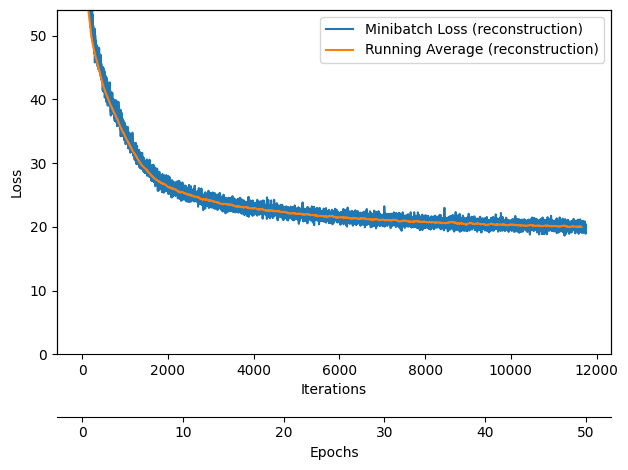

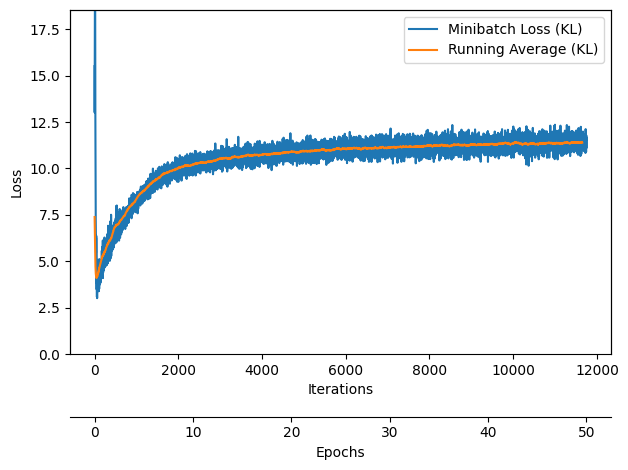

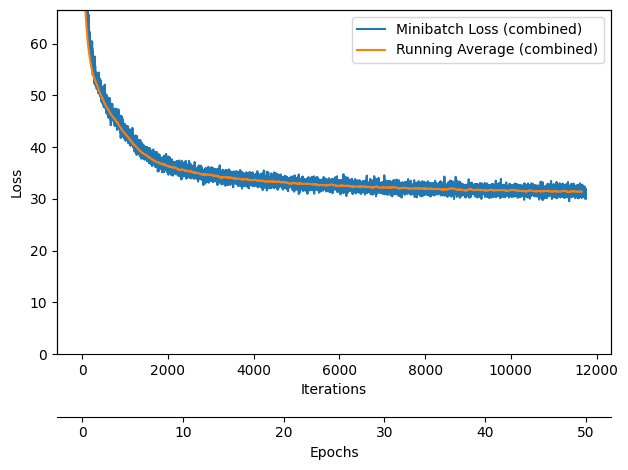

In [30]:
plot_training_loss(history_128d['train_reconstruction_loss_per_batch'], EPOCHS, custom_label=" (reconstruction)")
plot_training_loss(history_128d['train_kl_loss_per_batch'], EPOCHS, custom_label=" (KL)")
plot_training_loss(history_128d['train_combined_loss_per_batch'], EPOCHS, custom_label=" (combined)")
plt.show()

1. **Reconstruction Loss**
The loss drops sharply from the start and stabilizes around 20 after approximately 20 epochs. 
The model quickly achieved a high quality of reconstruction, which means that the decoder efficiently learned how to recreate the MNIST digits from the latent vectors.

2. **KL Divergence Loss**
The loss steeply increases from near zero and stabilizes around 11.5 after 15–20 epochs.
This indicates successful convergence of the latent space, as the model effectively forced the hidden distribution to follow normal distribution.

3. **Combined Loss**
VAE successfully balanced reconstruction quality and latent space regularization and achieved stable convergence.

In [ ]:
# Load model from file

#weights_path = os.path.join(SAVE_DIR, f"vae_weights_epoch_{EPOCHS}.pth")
#trained_model_128 = VAE(latent_dims=LATENT_DIM).to(DEVICE)
#trained_model_128.load_state_dict(torch.load(weights_path, map_location=DEVICE))

<All keys matched successfully>


 Reconstruction Quality (D=128)


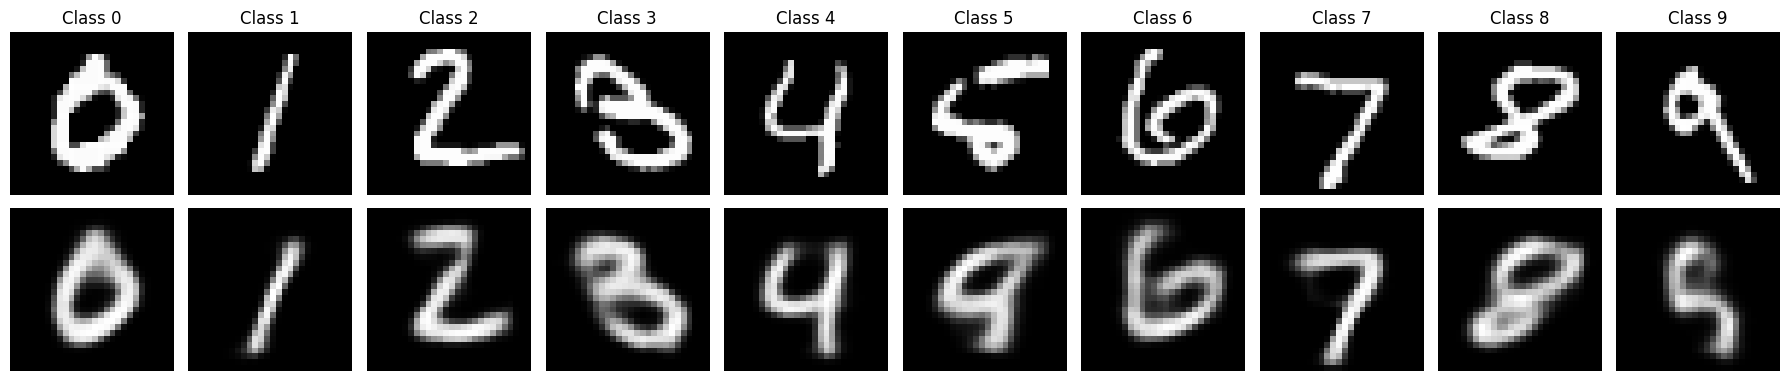


 Latent Space Evolution (D=128)

Generating t-SNE evolution for epochs: [1, 10, 30, 50]...


Processing t-SNE snapshots: 100%|██████████| 4/4 [01:08<00:00, 17.02s/it]


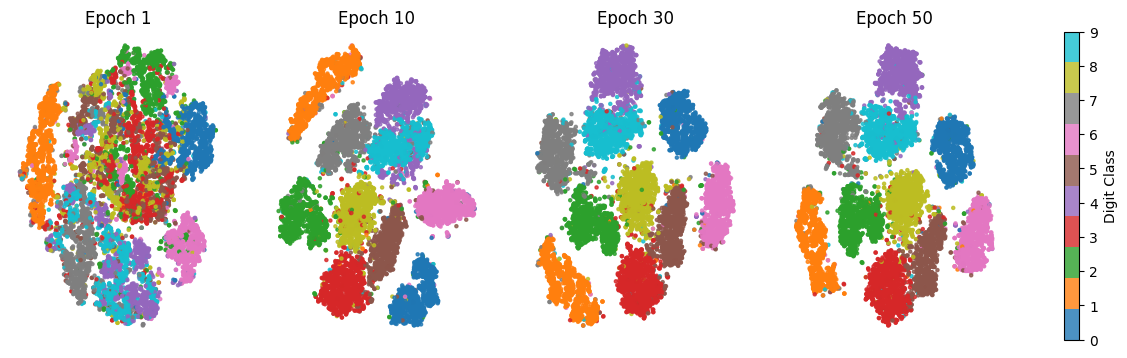


 Generated Samples (D=128)


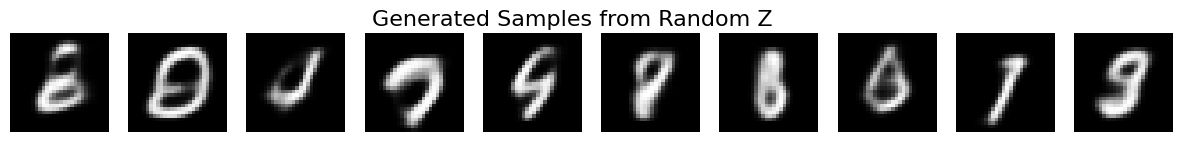


 Latent Space Interpolation (D=128)


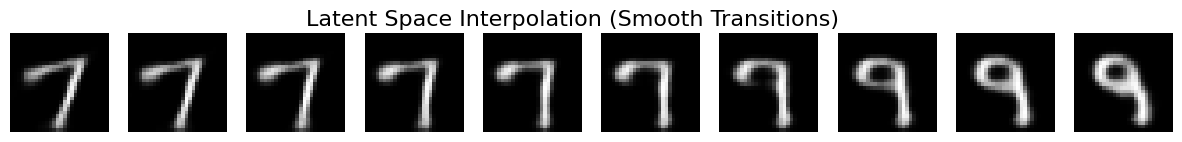

In [42]:

print("\n Reconstruction Quality (D=128)")
visualize_reconstruction(trained_model_128, test_loader, DEVICE)
print("\n Latent Space Evolution (D=128)")
visualize_latent_structure_evolution(VAE, LATENT_DIM, test_loader, DEVICE, [1, 10, 30, 50], weights_dir=SAVE_DIR)
print("\n Generated Samples (D=128)")
generate_samples(trained_model_128, LATENT_DIM, DEVICE)
print("\n Latent Space Interpolation (D=128)")
interpolate_samples(trained_model_128, LATENT_DIM, DEVICE)

### Results for latent dimensions = 128:
* **Reconstruction quality:**    
Overall reconstruction looks good for most of the digits. Only reconstructions for digits 5 and 9 doesn't resemble original images.

* **Laten Space evolution:**     
The model performed very significant improvement over the initial epochs (1-10). In the first epoch classes are partaially mixed together, whereas on epoch 10 they are separated. While there is little visible improvement after epoch 10, the final t-SNE plot shows that classes are quite well separated and clustered, indicating the model successfully learned feature space.    

* **Generated samples from Random Z vectors:**    
Most of the generated samples doesn't actually resemble original images and classes. They are very often confusing, as the model tends to mix two digits with each other. 

* **Latent Space interpolation:**     
The process shows smooth and continuous transition from digit 7 to 9.

# VAE training: latent dimensions = 256

In [ ]:
LATENT_DIM = 256
EPOCHS = 50
LR = 2e-4
LOGGING_INTERVAL = 50 

loss_fn = F.mse_loss
model = VAE(latent_dims=LATENT_DIM).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LR)
print(f"Starting VAE training with Latent Dims: {LATENT_DIM}")

SAVE_DIR = "vae_snapchots_d256"

trained_model_256, history_256d = train_vae(
    model=model,
    optimizer=optimizer,
    loss_fn=loss_fn,
    train_loader=train_loader, 
    NUM_EPOCHS=EPOCHS,
    device=DEVICE,
    logging_interval=LOGGING_INTERVAL,
    compute_epoch_loss_autoencoder=compute_epoch_loss_autoencoder, 
    skip_epoch_stats=False,
    save_dir=SAVE_DIR
)

Starting VAE training with Latent Dims: 256


Epoch 1/50 (Train):   0%|          | 1/235 [00:00<00:30,  7.59it/s]

Epoch: 001/050 | Batch 0000/0235 | Loss: 267.0488


Epoch 1/50 (Train):  24%|██▍       | 57/235 [00:01<00:05, 32.19it/s]

Epoch: 001/050 | Batch 0050/0235 | Loss: 87.2234


Epoch 1/50 (Train):  45%|████▍     | 105/235 [00:03<00:04, 32.25it/s]

Epoch: 001/050 | Batch 0100/0235 | Loss: 69.4101


Epoch 1/50 (Train):  67%|██████▋   | 157/235 [00:04<00:02, 32.21it/s]

Epoch: 001/050 | Batch 0150/0235 | Loss: 62.4519


Epoch 1/50 (Train):  87%|████████▋ | 205/235 [00:06<00:00, 32.19it/s]

Epoch: 001/050 | Batch 0200/0235 | Loss: 58.0690


Epoch 1/50 (Train): 100%|██████████| 235/235 [00:07<00:00, 31.69it/s]


***Epoch: 001/050 | Loss: 48.587
Time elapsed: 0.17 min


Epoch 2/50 (Train):   0%|          | 1/235 [00:00<00:27,  8.37it/s]

Epoch: 002/050 | Batch 0000/0235 | Loss: 58.5729


Epoch 2/50 (Train):  24%|██▍       | 57/235 [00:01<00:05, 32.15it/s]

Epoch: 002/050 | Batch 0050/0235 | Loss: 56.2540


Epoch 2/50 (Train):  45%|████▍     | 105/235 [00:03<00:04, 32.13it/s]

Epoch: 002/050 | Batch 0100/0235 | Loss: 54.4301


Epoch 2/50 (Train):  67%|██████▋   | 157/235 [00:04<00:02, 32.17it/s]

Epoch: 002/050 | Batch 0150/0235 | Loss: 52.6116


Epoch 2/50 (Train):  87%|████████▋ | 205/235 [00:06<00:00, 32.16it/s]

Epoch: 002/050 | Batch 0200/0235 | Loss: 52.6569


Epoch 2/50 (Train): 100%|██████████| 235/235 [00:07<00:00, 31.71it/s]


***Epoch: 002/050 | Loss: 43.288
Time elapsed: 0.33 min


Epoch 3/50 (Train):   0%|          | 1/235 [00:00<00:27,  8.40it/s]

Epoch: 003/050 | Batch 0000/0235 | Loss: 51.6594


Epoch 3/50 (Train):  24%|██▍       | 57/235 [00:01<00:05, 32.11it/s]

Epoch: 003/050 | Batch 0050/0235 | Loss: 49.6443


Epoch 3/50 (Train):  45%|████▍     | 105/235 [00:03<00:04, 32.14it/s]

Epoch: 003/050 | Batch 0100/0235 | Loss: 49.2482


Epoch 3/50 (Train):  67%|██████▋   | 157/235 [00:04<00:02, 32.23it/s]

Epoch: 003/050 | Batch 0150/0235 | Loss: 49.1229


Epoch 3/50 (Train):  87%|████████▋ | 205/235 [00:06<00:00, 32.14it/s]

Epoch: 003/050 | Batch 0200/0235 | Loss: 49.0832


Epoch 3/50 (Train): 100%|██████████| 235/235 [00:07<00:00, 31.74it/s]


***Epoch: 003/050 | Loss: 38.839
Time elapsed: 0.50 min


Epoch 4/50 (Train):   0%|          | 1/235 [00:00<00:28,  8.30it/s]

Epoch: 004/050 | Batch 0000/0235 | Loss: 49.0971


Epoch 4/50 (Train):  24%|██▍       | 57/235 [00:01<00:05, 32.17it/s]

Epoch: 004/050 | Batch 0050/0235 | Loss: 47.4972


Epoch 4/50 (Train):  45%|████▍     | 105/235 [00:03<00:04, 32.21it/s]

Epoch: 004/050 | Batch 0100/0235 | Loss: 47.2166


Epoch 4/50 (Train):  67%|██████▋   | 157/235 [00:04<00:02, 32.19it/s]

Epoch: 004/050 | Batch 0150/0235 | Loss: 46.9596


Epoch 4/50 (Train):  87%|████████▋ | 205/235 [00:06<00:00, 32.08it/s]

Epoch: 004/050 | Batch 0200/0235 | Loss: 45.0955


Epoch 4/50 (Train): 100%|██████████| 235/235 [00:07<00:00, 31.71it/s]


***Epoch: 004/050 | Loss: 35.853
Time elapsed: 0.67 min


Epoch 5/50 (Train):   0%|          | 1/235 [00:00<00:28,  8.28it/s]

Epoch: 005/050 | Batch 0000/0235 | Loss: 45.1991


Epoch 5/50 (Train):  24%|██▍       | 57/235 [00:01<00:05, 32.15it/s]

Epoch: 005/050 | Batch 0050/0235 | Loss: 43.3839


Epoch 5/50 (Train):  45%|████▍     | 105/235 [00:03<00:04, 32.03it/s]

Epoch: 005/050 | Batch 0100/0235 | Loss: 46.1598


Epoch 5/50 (Train):  67%|██████▋   | 157/235 [00:04<00:02, 32.08it/s]

Epoch: 005/050 | Batch 0150/0235 | Loss: 45.1106


Epoch 5/50 (Train):  87%|████████▋ | 205/235 [00:06<00:00, 32.08it/s]

Epoch: 005/050 | Batch 0200/0235 | Loss: 45.4326


Epoch 5/50 (Train): 100%|██████████| 235/235 [00:07<00:00, 31.65it/s]


***Epoch: 005/050 | Loss: 34.010
Time elapsed: 0.83 min


Epoch 6/50 (Train):   0%|          | 1/235 [00:00<00:28,  8.34it/s]

Epoch: 006/050 | Batch 0000/0235 | Loss: 44.9091


Epoch 6/50 (Train):  24%|██▍       | 57/235 [00:01<00:05, 32.14it/s]

Epoch: 006/050 | Batch 0050/0235 | Loss: 43.4844


Epoch 6/50 (Train):  45%|████▍     | 105/235 [00:03<00:04, 32.11it/s]

Epoch: 006/050 | Batch 0100/0235 | Loss: 43.8102


Epoch 6/50 (Train):  67%|██████▋   | 157/235 [00:04<00:02, 32.20it/s]

Epoch: 006/050 | Batch 0150/0235 | Loss: 40.9351


Epoch 6/50 (Train):  87%|████████▋ | 205/235 [00:06<00:00, 32.21it/s]

Epoch: 006/050 | Batch 0200/0235 | Loss: 42.4448


Epoch 6/50 (Train): 100%|██████████| 235/235 [00:07<00:00, 31.69it/s]


***Epoch: 006/050 | Loss: 31.093
Time elapsed: 1.00 min


Epoch 7/50 (Train):   0%|          | 1/235 [00:00<00:29,  7.89it/s]

Epoch: 007/050 | Batch 0000/0235 | Loss: 43.2790


Epoch 7/50 (Train):  24%|██▍       | 57/235 [00:01<00:05, 32.08it/s]

Epoch: 007/050 | Batch 0050/0235 | Loss: 42.0674


Epoch 7/50 (Train):  45%|████▍     | 105/235 [00:03<00:04, 32.08it/s]

Epoch: 007/050 | Batch 0100/0235 | Loss: 41.3006


Epoch 7/50 (Train):  67%|██████▋   | 157/235 [00:04<00:02, 32.09it/s]

Epoch: 007/050 | Batch 0150/0235 | Loss: 41.0327


Epoch 7/50 (Train):  87%|████████▋ | 205/235 [00:06<00:00, 32.06it/s]

Epoch: 007/050 | Batch 0200/0235 | Loss: 41.5187


Epoch 7/50 (Train): 100%|██████████| 235/235 [00:07<00:00, 31.61it/s]


***Epoch: 007/050 | Loss: 28.908
Time elapsed: 1.17 min


Epoch 8/50 (Train):   0%|          | 1/235 [00:00<00:28,  8.29it/s]

Epoch: 008/050 | Batch 0000/0235 | Loss: 40.2644


Epoch 8/50 (Train):  24%|██▍       | 57/235 [00:01<00:05, 32.10it/s]

Epoch: 008/050 | Batch 0050/0235 | Loss: 40.4800


Epoch 8/50 (Train):  45%|████▍     | 105/235 [00:03<00:04, 32.10it/s]

Epoch: 008/050 | Batch 0100/0235 | Loss: 39.1786


Epoch 8/50 (Train):  67%|██████▋   | 157/235 [00:04<00:02, 32.04it/s]

Epoch: 008/050 | Batch 0150/0235 | Loss: 39.0471


Epoch 8/50 (Train):  87%|████████▋ | 205/235 [00:06<00:00, 32.13it/s]

Epoch: 008/050 | Batch 0200/0235 | Loss: 39.2913


Epoch 8/50 (Train): 100%|██████████| 235/235 [00:07<00:00, 31.65it/s]


***Epoch: 008/050 | Loss: 27.701
Time elapsed: 1.33 min


Epoch 9/50 (Train):   0%|          | 1/235 [00:00<00:30,  7.78it/s]

Epoch: 009/050 | Batch 0000/0235 | Loss: 39.3557


Epoch 9/50 (Train):  24%|██▍       | 57/235 [00:01<00:05, 32.22it/s]

Epoch: 009/050 | Batch 0050/0235 | Loss: 37.4242


Epoch 9/50 (Train):  45%|████▍     | 105/235 [00:03<00:04, 32.02it/s]

Epoch: 009/050 | Batch 0100/0235 | Loss: 39.7178


Epoch 9/50 (Train):  67%|██████▋   | 157/235 [00:04<00:02, 32.10it/s]

Epoch: 009/050 | Batch 0150/0235 | Loss: 39.3215


Epoch 9/50 (Train):  87%|████████▋ | 205/235 [00:06<00:00, 32.07it/s]

Epoch: 009/050 | Batch 0200/0235 | Loss: 37.3203


Epoch 9/50 (Train): 100%|██████████| 235/235 [00:07<00:00, 31.59it/s]


***Epoch: 009/050 | Loss: 26.423
Time elapsed: 1.50 min


Epoch 10/50 (Train):   0%|          | 1/235 [00:00<00:28,  8.35it/s]

Epoch: 010/050 | Batch 0000/0235 | Loss: 38.2266


Epoch 10/50 (Train):  24%|██▍       | 57/235 [00:01<00:05, 32.13it/s]

Epoch: 010/050 | Batch 0050/0235 | Loss: 37.8789


Epoch 10/50 (Train):  45%|████▍     | 105/235 [00:03<00:04, 32.02it/s]

Epoch: 010/050 | Batch 0100/0235 | Loss: 37.3163


Epoch 10/50 (Train):  67%|██████▋   | 157/235 [00:04<00:02, 32.12it/s]

Epoch: 010/050 | Batch 0150/0235 | Loss: 38.0226


Epoch 10/50 (Train):  87%|████████▋ | 205/235 [00:06<00:00, 32.04it/s]

Epoch: 010/050 | Batch 0200/0235 | Loss: 37.2171


Epoch 10/50 (Train): 100%|██████████| 235/235 [00:07<00:00, 31.61it/s]


***Epoch: 010/050 | Loss: 25.785
Time elapsed: 1.67 min


Epoch 11/50 (Train):   0%|          | 1/235 [00:00<00:28,  8.34it/s]

Epoch: 011/050 | Batch 0000/0235 | Loss: 36.7720


Epoch 11/50 (Train):  24%|██▍       | 57/235 [00:01<00:05, 32.04it/s]

Epoch: 011/050 | Batch 0050/0235 | Loss: 37.4357


Epoch 11/50 (Train):  45%|████▍     | 105/235 [00:03<00:04, 32.14it/s]

Epoch: 011/050 | Batch 0100/0235 | Loss: 36.3878


Epoch 11/50 (Train):  67%|██████▋   | 157/235 [00:04<00:02, 32.11it/s]

Epoch: 011/050 | Batch 0150/0235 | Loss: 36.7028


Epoch 11/50 (Train):  87%|████████▋ | 205/235 [00:06<00:00, 32.20it/s]

Epoch: 011/050 | Batch 0200/0235 | Loss: 36.4252


Epoch 11/50 (Train): 100%|██████████| 235/235 [00:07<00:00, 31.64it/s]


***Epoch: 011/050 | Loss: 24.998
Time elapsed: 1.83 min


Epoch 12/50 (Train):   0%|          | 1/235 [00:00<00:28,  8.23it/s]

Epoch: 012/050 | Batch 0000/0235 | Loss: 35.7549


Epoch 12/50 (Train):  24%|██▍       | 57/235 [00:01<00:05, 32.06it/s]

Epoch: 012/050 | Batch 0050/0235 | Loss: 36.8318


Epoch 12/50 (Train):  45%|████▍     | 105/235 [00:03<00:04, 32.11it/s]

Epoch: 012/050 | Batch 0100/0235 | Loss: 36.8659


Epoch 12/50 (Train):  67%|██████▋   | 157/235 [00:04<00:02, 32.17it/s]

Epoch: 012/050 | Batch 0150/0235 | Loss: 35.9269


Epoch 12/50 (Train):  87%|████████▋ | 205/235 [00:06<00:00, 32.02it/s]

Epoch: 012/050 | Batch 0200/0235 | Loss: 36.8675


Epoch 12/50 (Train): 100%|██████████| 235/235 [00:07<00:00, 31.62it/s]


***Epoch: 012/050 | Loss: 24.783
Time elapsed: 2.00 min


Epoch 13/50 (Train):   0%|          | 1/235 [00:00<00:28,  8.11it/s]

Epoch: 013/050 | Batch 0000/0235 | Loss: 36.9772


Epoch 13/50 (Train):  24%|██▍       | 57/235 [00:01<00:05, 32.09it/s]

Epoch: 013/050 | Batch 0050/0235 | Loss: 36.4524


Epoch 13/50 (Train):  45%|████▍     | 105/235 [00:03<00:04, 32.17it/s]

Epoch: 013/050 | Batch 0100/0235 | Loss: 35.4666


Epoch 13/50 (Train):  67%|██████▋   | 157/235 [00:04<00:02, 32.17it/s]

Epoch: 013/050 | Batch 0150/0235 | Loss: 35.5854


Epoch 13/50 (Train):  87%|████████▋ | 205/235 [00:06<00:00, 32.14it/s]

Epoch: 013/050 | Batch 0200/0235 | Loss: 36.6297


Epoch 13/50 (Train): 100%|██████████| 235/235 [00:07<00:00, 31.68it/s]


***Epoch: 013/050 | Loss: 24.193
Time elapsed: 2.17 min


Epoch 14/50 (Train):   0%|          | 1/235 [00:00<00:32,  7.26it/s]

Epoch: 014/050 | Batch 0000/0235 | Loss: 35.7225


Epoch 14/50 (Train):  24%|██▍       | 57/235 [00:01<00:05, 32.08it/s]

Epoch: 014/050 | Batch 0050/0235 | Loss: 35.8787


Epoch 14/50 (Train):  45%|████▍     | 105/235 [00:03<00:04, 31.99it/s]

Epoch: 014/050 | Batch 0100/0235 | Loss: 37.2624


Epoch 14/50 (Train):  67%|██████▋   | 157/235 [00:04<00:02, 32.10it/s]

Epoch: 014/050 | Batch 0150/0235 | Loss: 35.6160


Epoch 14/50 (Train):  87%|████████▋ | 205/235 [00:06<00:00, 32.09it/s]

Epoch: 014/050 | Batch 0200/0235 | Loss: 36.3288


Epoch 14/50 (Train): 100%|██████████| 235/235 [00:07<00:00, 31.58it/s]


***Epoch: 014/050 | Loss: 23.689
Time elapsed: 2.33 min


Epoch 15/50 (Train):   0%|          | 1/235 [00:00<00:29,  7.82it/s]

Epoch: 015/050 | Batch 0000/0235 | Loss: 36.5103


Epoch 15/50 (Train):  24%|██▍       | 57/235 [00:01<00:05, 32.11it/s]

Epoch: 015/050 | Batch 0050/0235 | Loss: 34.7380


Epoch 15/50 (Train):  45%|████▍     | 105/235 [00:03<00:04, 32.09it/s]

Epoch: 015/050 | Batch 0100/0235 | Loss: 36.0751


Epoch 15/50 (Train):  67%|██████▋   | 157/235 [00:04<00:02, 32.14it/s]

Epoch: 015/050 | Batch 0150/0235 | Loss: 35.2203


Epoch 15/50 (Train):  87%|████████▋ | 205/235 [00:06<00:00, 32.09it/s]

Epoch: 015/050 | Batch 0200/0235 | Loss: 34.3488


Epoch 15/50 (Train): 100%|██████████| 235/235 [00:07<00:00, 31.60it/s]


***Epoch: 015/050 | Loss: 23.073
Time elapsed: 2.50 min


Epoch 16/50 (Train):   0%|          | 1/235 [00:00<00:28,  8.17it/s]

Epoch: 016/050 | Batch 0000/0235 | Loss: 35.2569


Epoch 16/50 (Train):  24%|██▍       | 57/235 [00:01<00:05, 32.12it/s]

Epoch: 016/050 | Batch 0050/0235 | Loss: 36.3591


Epoch 16/50 (Train):  45%|████▍     | 105/235 [00:03<00:04, 32.03it/s]

Epoch: 016/050 | Batch 0100/0235 | Loss: 35.2058


Epoch 16/50 (Train):  67%|██████▋   | 157/235 [00:04<00:02, 32.08it/s]

Epoch: 016/050 | Batch 0150/0235 | Loss: 35.7011


Epoch 16/50 (Train):  87%|████████▋ | 205/235 [00:06<00:00, 32.19it/s]

Epoch: 016/050 | Batch 0200/0235 | Loss: 34.9281


Epoch 16/50 (Train): 100%|██████████| 235/235 [00:07<00:00, 31.62it/s]


***Epoch: 016/050 | Loss: 22.628
Time elapsed: 2.67 min


Epoch 17/50 (Train):   0%|          | 1/235 [00:00<00:28,  8.35it/s]

Epoch: 017/050 | Batch 0000/0235 | Loss: 34.0328


Epoch 17/50 (Train):  24%|██▍       | 57/235 [00:01<00:05, 32.13it/s]

Epoch: 017/050 | Batch 0050/0235 | Loss: 34.3811


Epoch 17/50 (Train):  45%|████▍     | 105/235 [00:03<00:04, 32.13it/s]

Epoch: 017/050 | Batch 0100/0235 | Loss: 34.8184


Epoch 17/50 (Train):  67%|██████▋   | 157/235 [00:04<00:02, 31.87it/s]

Epoch: 017/050 | Batch 0150/0235 | Loss: 34.4377


Epoch 17/50 (Train):  87%|████████▋ | 205/235 [00:06<00:00, 32.03it/s]

Epoch: 017/050 | Batch 0200/0235 | Loss: 33.8367


Epoch 17/50 (Train): 100%|██████████| 235/235 [00:07<00:00, 31.60it/s]


***Epoch: 017/050 | Loss: 21.964
Time elapsed: 2.83 min


Epoch 18/50 (Train):   0%|          | 1/235 [00:00<00:28,  8.33it/s]

Epoch: 018/050 | Batch 0000/0235 | Loss: 35.1654


Epoch 18/50 (Train):  24%|██▍       | 57/235 [00:01<00:05, 31.96it/s]

Epoch: 018/050 | Batch 0050/0235 | Loss: 34.5718


Epoch 18/50 (Train):  45%|████▍     | 105/235 [00:03<00:04, 32.01it/s]

Epoch: 018/050 | Batch 0100/0235 | Loss: 35.1179


Epoch 18/50 (Train):  67%|██████▋   | 157/235 [00:04<00:02, 32.06it/s]

Epoch: 018/050 | Batch 0150/0235 | Loss: 34.1771


Epoch 18/50 (Train):  87%|████████▋ | 205/235 [00:06<00:00, 32.10it/s]

Epoch: 018/050 | Batch 0200/0235 | Loss: 34.1955


Epoch 18/50 (Train): 100%|██████████| 235/235 [00:07<00:00, 31.59it/s]


***Epoch: 018/050 | Loss: 21.642
Time elapsed: 3.00 min


Epoch 19/50 (Train):   0%|          | 1/235 [00:00<00:31,  7.52it/s]

Epoch: 019/050 | Batch 0000/0235 | Loss: 34.8562


Epoch 19/50 (Train):  24%|██▍       | 57/235 [00:01<00:05, 32.04it/s]

Epoch: 019/050 | Batch 0050/0235 | Loss: 34.0031


Epoch 19/50 (Train):  45%|████▍     | 105/235 [00:03<00:04, 31.96it/s]

Epoch: 019/050 | Batch 0100/0235 | Loss: 33.8899


Epoch 19/50 (Train):  67%|██████▋   | 157/235 [00:04<00:02, 32.05it/s]

Epoch: 019/050 | Batch 0150/0235 | Loss: 34.7950


Epoch 19/50 (Train):  87%|████████▋ | 205/235 [00:06<00:00, 31.98it/s]

Epoch: 019/050 | Batch 0200/0235 | Loss: 34.5415


Epoch 19/50 (Train): 100%|██████████| 235/235 [00:07<00:00, 31.54it/s]


***Epoch: 019/050 | Loss: 21.342
Time elapsed: 3.17 min


Epoch 20/50 (Train):   0%|          | 1/235 [00:00<00:30,  7.76it/s]

Epoch: 020/050 | Batch 0000/0235 | Loss: 34.4177


Epoch 20/50 (Train):  24%|██▍       | 57/235 [00:01<00:05, 32.07it/s]

Epoch: 020/050 | Batch 0050/0235 | Loss: 33.7203


Epoch 20/50 (Train):  45%|████▍     | 105/235 [00:03<00:04, 31.96it/s]

Epoch: 020/050 | Batch 0100/0235 | Loss: 34.7412


Epoch 20/50 (Train):  67%|██████▋   | 157/235 [00:05<00:02, 32.09it/s]

Epoch: 020/050 | Batch 0150/0235 | Loss: 33.5480


Epoch 20/50 (Train):  87%|████████▋ | 205/235 [00:06<00:00, 32.13it/s]

Epoch: 020/050 | Batch 0200/0235 | Loss: 33.5744


Epoch 20/50 (Train): 100%|██████████| 235/235 [00:07<00:00, 31.56it/s]


***Epoch: 020/050 | Loss: 21.150
Time elapsed: 3.33 min


Epoch 21/50 (Train):   0%|          | 1/235 [00:00<00:30,  7.55it/s]

Epoch: 021/050 | Batch 0000/0235 | Loss: 32.6853


Epoch 21/50 (Train):  24%|██▍       | 57/235 [00:01<00:05, 32.04it/s]

Epoch: 021/050 | Batch 0050/0235 | Loss: 35.1601


Epoch 21/50 (Train):  45%|████▍     | 105/235 [00:03<00:04, 31.96it/s]

Epoch: 021/050 | Batch 0100/0235 | Loss: 34.3016


Epoch 21/50 (Train):  67%|██████▋   | 157/235 [00:05<00:02, 32.13it/s]

Epoch: 021/050 | Batch 0150/0235 | Loss: 34.0313


Epoch 21/50 (Train):  87%|████████▋ | 205/235 [00:06<00:00, 32.11it/s]

Epoch: 021/050 | Batch 0200/0235 | Loss: 33.2327


Epoch 21/50 (Train): 100%|██████████| 235/235 [00:07<00:00, 31.54it/s]


***Epoch: 021/050 | Loss: 20.991
Time elapsed: 3.50 min


Epoch 22/50 (Train):   0%|          | 1/235 [00:00<00:28,  8.21it/s]

Epoch: 022/050 | Batch 0000/0235 | Loss: 34.2262


Epoch 22/50 (Train):  24%|██▍       | 57/235 [00:01<00:05, 32.07it/s]

Epoch: 022/050 | Batch 0050/0235 | Loss: 33.2325


Epoch 22/50 (Train):  45%|████▍     | 105/235 [00:03<00:04, 32.09it/s]

Epoch: 022/050 | Batch 0100/0235 | Loss: 33.4242


Epoch 22/50 (Train):  67%|██████▋   | 157/235 [00:04<00:02, 32.02it/s]

Epoch: 022/050 | Batch 0150/0235 | Loss: 33.2099


Epoch 22/50 (Train):  87%|████████▋ | 205/235 [00:06<00:00, 32.16it/s]

Epoch: 022/050 | Batch 0200/0235 | Loss: 33.2891


Epoch 22/50 (Train): 100%|██████████| 235/235 [00:07<00:00, 31.63it/s]


***Epoch: 022/050 | Loss: 20.577
Time elapsed: 3.67 min


Epoch 23/50 (Train):   0%|          | 1/235 [00:00<00:28,  8.12it/s]

Epoch: 023/050 | Batch 0000/0235 | Loss: 33.6439


Epoch 23/50 (Train):  24%|██▍       | 57/235 [00:01<00:05, 31.97it/s]

Epoch: 023/050 | Batch 0050/0235 | Loss: 33.8522


Epoch 23/50 (Train):  45%|████▍     | 105/235 [00:03<00:04, 32.09it/s]

Epoch: 023/050 | Batch 0100/0235 | Loss: 32.4050


Epoch 23/50 (Train):  67%|██████▋   | 157/235 [00:04<00:02, 32.01it/s]

Epoch: 023/050 | Batch 0150/0235 | Loss: 32.7618


Epoch 23/50 (Train):  87%|████████▋ | 205/235 [00:06<00:00, 32.15it/s]

Epoch: 023/050 | Batch 0200/0235 | Loss: 33.7431


Epoch 23/50 (Train): 100%|██████████| 235/235 [00:07<00:00, 31.56it/s]


***Epoch: 023/050 | Loss: 20.531
Time elapsed: 3.84 min


Epoch 24/50 (Train):   0%|          | 1/235 [00:00<00:28,  8.34it/s]

Epoch: 024/050 | Batch 0000/0235 | Loss: 33.2715


Epoch 24/50 (Train):  24%|██▍       | 57/235 [00:01<00:05, 32.10it/s]

Epoch: 024/050 | Batch 0050/0235 | Loss: 33.0305


Epoch 24/50 (Train):  45%|████▍     | 105/235 [00:03<00:04, 32.04it/s]

Epoch: 024/050 | Batch 0100/0235 | Loss: 31.8518


Epoch 24/50 (Train):  67%|██████▋   | 157/235 [00:04<00:02, 32.05it/s]

Epoch: 024/050 | Batch 0150/0235 | Loss: 33.0168


Epoch 24/50 (Train):  87%|████████▋ | 205/235 [00:06<00:00, 32.12it/s]

Epoch: 024/050 | Batch 0200/0235 | Loss: 34.7236


Epoch 24/50 (Train): 100%|██████████| 235/235 [00:07<00:00, 31.61it/s]


***Epoch: 024/050 | Loss: 20.524
Time elapsed: 4.00 min


Epoch 25/50 (Train):   0%|          | 1/235 [00:00<00:28,  8.34it/s]

Epoch: 025/050 | Batch 0000/0235 | Loss: 34.1005


Epoch 25/50 (Train):  24%|██▍       | 57/235 [00:01<00:05, 32.11it/s]

Epoch: 025/050 | Batch 0050/0235 | Loss: 33.6219


Epoch 25/50 (Train):  45%|████▍     | 105/235 [00:03<00:04, 31.96it/s]

Epoch: 025/050 | Batch 0100/0235 | Loss: 34.8390


Epoch 25/50 (Train):  67%|██████▋   | 157/235 [00:04<00:02, 32.02it/s]

Epoch: 025/050 | Batch 0150/0235 | Loss: 33.2193


Epoch 25/50 (Train):  87%|████████▋ | 205/235 [00:06<00:00, 31.98it/s]

Epoch: 025/050 | Batch 0200/0235 | Loss: 33.4323


Epoch 25/50 (Train): 100%|██████████| 235/235 [00:07<00:00, 31.56it/s]


***Epoch: 025/050 | Loss: 20.261
Time elapsed: 4.17 min


Epoch 26/50 (Train):   0%|          | 1/235 [00:00<00:28,  8.27it/s]

Epoch: 026/050 | Batch 0000/0235 | Loss: 32.3246


Epoch 26/50 (Train):  24%|██▍       | 57/235 [00:01<00:05, 31.97it/s]

Epoch: 026/050 | Batch 0050/0235 | Loss: 33.3446


Epoch 26/50 (Train):  45%|████▍     | 105/235 [00:03<00:04, 32.18it/s]

Epoch: 026/050 | Batch 0100/0235 | Loss: 32.7825


Epoch 26/50 (Train):  67%|██████▋   | 157/235 [00:04<00:02, 32.05it/s]

Epoch: 026/050 | Batch 0150/0235 | Loss: 32.6364


Epoch 26/50 (Train):  87%|████████▋ | 205/235 [00:06<00:00, 32.09it/s]

Epoch: 026/050 | Batch 0200/0235 | Loss: 33.3418


Epoch 26/50 (Train): 100%|██████████| 235/235 [00:07<00:00, 31.64it/s]


***Epoch: 026/050 | Loss: 19.946
Time elapsed: 4.34 min


Epoch 27/50 (Train):   0%|          | 1/235 [00:00<00:28,  8.19it/s]

Epoch: 027/050 | Batch 0000/0235 | Loss: 32.4499


Epoch 27/50 (Train):  24%|██▍       | 57/235 [00:01<00:05, 32.02it/s]

Epoch: 027/050 | Batch 0050/0235 | Loss: 32.9301


Epoch 27/50 (Train):  45%|████▍     | 105/235 [00:03<00:04, 32.00it/s]

Epoch: 027/050 | Batch 0100/0235 | Loss: 33.4928


Epoch 27/50 (Train):  67%|██████▋   | 157/235 [00:04<00:02, 32.03it/s]

Epoch: 027/050 | Batch 0150/0235 | Loss: 32.6722


Epoch 27/50 (Train):  87%|████████▋ | 205/235 [00:06<00:00, 32.13it/s]

Epoch: 027/050 | Batch 0200/0235 | Loss: 33.6626


Epoch 27/50 (Train): 100%|██████████| 235/235 [00:07<00:00, 31.59it/s]


***Epoch: 027/050 | Loss: 20.074
Time elapsed: 4.50 min


Epoch 28/50 (Train):   0%|          | 1/235 [00:00<00:28,  8.26it/s]

Epoch: 028/050 | Batch 0000/0235 | Loss: 32.2505


Epoch 28/50 (Train):  24%|██▍       | 57/235 [00:01<00:05, 32.03it/s]

Epoch: 028/050 | Batch 0050/0235 | Loss: 33.0508


Epoch 28/50 (Train):  45%|████▍     | 105/235 [00:03<00:04, 31.95it/s]

Epoch: 028/050 | Batch 0100/0235 | Loss: 32.1895


Epoch 28/50 (Train):  67%|██████▋   | 157/235 [00:04<00:02, 32.08it/s]

Epoch: 028/050 | Batch 0150/0235 | Loss: 32.5951


Epoch 28/50 (Train):  87%|████████▋ | 205/235 [00:06<00:00, 32.08it/s]

Epoch: 028/050 | Batch 0200/0235 | Loss: 32.8377


Epoch 28/50 (Train): 100%|██████████| 235/235 [00:07<00:00, 31.59it/s]


***Epoch: 028/050 | Loss: 19.829
Time elapsed: 4.67 min


Epoch 29/50 (Train):   0%|          | 1/235 [00:00<00:28,  8.27it/s]

Epoch: 029/050 | Batch 0000/0235 | Loss: 32.6495


Epoch 29/50 (Train):  24%|██▍       | 57/235 [00:01<00:05, 31.92it/s]

Epoch: 029/050 | Batch 0050/0235 | Loss: 32.3568


Epoch 29/50 (Train):  45%|████▍     | 105/235 [00:03<00:04, 32.06it/s]

Epoch: 029/050 | Batch 0100/0235 | Loss: 33.0069


Epoch 29/50 (Train):  67%|██████▋   | 157/235 [00:04<00:02, 32.08it/s]

Epoch: 029/050 | Batch 0150/0235 | Loss: 31.6776


Epoch 29/50 (Train):  87%|████████▋ | 205/235 [00:06<00:00, 31.97it/s]

Epoch: 029/050 | Batch 0200/0235 | Loss: 32.2303


Epoch 29/50 (Train): 100%|██████████| 235/235 [00:07<00:00, 31.57it/s]


***Epoch: 029/050 | Loss: 19.765
Time elapsed: 4.84 min


Epoch 30/50 (Train):   0%|          | 1/235 [00:00<00:28,  8.22it/s]

Epoch: 030/050 | Batch 0000/0235 | Loss: 32.1617


Epoch 30/50 (Train):  24%|██▍       | 57/235 [00:01<00:05, 32.07it/s]

Epoch: 030/050 | Batch 0050/0235 | Loss: 32.3363


Epoch 30/50 (Train):  45%|████▍     | 105/235 [00:03<00:04, 32.02it/s]

Epoch: 030/050 | Batch 0100/0235 | Loss: 32.9322


Epoch 30/50 (Train):  67%|██████▋   | 157/235 [00:04<00:02, 32.14it/s]

Epoch: 030/050 | Batch 0150/0235 | Loss: 33.4346


Epoch 30/50 (Train):  87%|████████▋ | 205/235 [00:06<00:00, 31.81it/s]

Epoch: 030/050 | Batch 0200/0235 | Loss: 33.1846


Epoch 30/50 (Train): 100%|██████████| 235/235 [00:07<00:00, 31.55it/s]


***Epoch: 030/050 | Loss: 19.414
Time elapsed: 5.01 min


Epoch 31/50 (Train):   0%|          | 1/235 [00:00<00:30,  7.78it/s]

Epoch: 031/050 | Batch 0000/0235 | Loss: 32.2287


Epoch 31/50 (Train):  24%|██▍       | 57/235 [00:01<00:05, 31.94it/s]

Epoch: 031/050 | Batch 0050/0235 | Loss: 32.2685


Epoch 31/50 (Train):  45%|████▍     | 105/235 [00:03<00:04, 32.15it/s]

Epoch: 031/050 | Batch 0100/0235 | Loss: 33.9042


Epoch 31/50 (Train):  67%|██████▋   | 157/235 [00:04<00:02, 32.11it/s]

Epoch: 031/050 | Batch 0150/0235 | Loss: 32.5053


Epoch 31/50 (Train):  87%|████████▋ | 205/235 [00:06<00:00, 32.01it/s]

Epoch: 031/050 | Batch 0200/0235 | Loss: 32.0358


Epoch 31/50 (Train): 100%|██████████| 235/235 [00:07<00:00, 31.56it/s]


***Epoch: 031/050 | Loss: 19.271
Time elapsed: 5.17 min


Epoch 32/50 (Train):   0%|          | 1/235 [00:00<00:28,  8.10it/s]

Epoch: 032/050 | Batch 0000/0235 | Loss: 32.3160


Epoch 32/50 (Train):  24%|██▍       | 57/235 [00:01<00:05, 32.05it/s]

Epoch: 032/050 | Batch 0050/0235 | Loss: 31.7161


Epoch 32/50 (Train):  45%|████▍     | 105/235 [00:03<00:04, 32.10it/s]

Epoch: 032/050 | Batch 0100/0235 | Loss: 32.6558


Epoch 32/50 (Train):  67%|██████▋   | 157/235 [00:04<00:02, 32.12it/s]

Epoch: 032/050 | Batch 0150/0235 | Loss: 31.8904


Epoch 32/50 (Train):  87%|████████▋ | 205/235 [00:06<00:00, 31.98it/s]

Epoch: 032/050 | Batch 0200/0235 | Loss: 31.8791


Epoch 32/50 (Train): 100%|██████████| 235/235 [00:07<00:00, 31.58it/s]


***Epoch: 032/050 | Loss: 19.050
Time elapsed: 5.34 min


Epoch 33/50 (Train):   0%|          | 1/235 [00:00<00:28,  8.28it/s]

Epoch: 033/050 | Batch 0000/0235 | Loss: 32.2387


Epoch 33/50 (Train):  24%|██▍       | 57/235 [00:01<00:05, 32.13it/s]

Epoch: 033/050 | Batch 0050/0235 | Loss: 32.6502


Epoch 33/50 (Train):  45%|████▍     | 105/235 [00:03<00:04, 32.14it/s]

Epoch: 033/050 | Batch 0100/0235 | Loss: 31.5613


Epoch 33/50 (Train):  67%|██████▋   | 157/235 [00:04<00:02, 32.09it/s]

Epoch: 033/050 | Batch 0150/0235 | Loss: 32.4929


Epoch 33/50 (Train):  87%|████████▋ | 205/235 [00:06<00:00, 32.07it/s]

Epoch: 033/050 | Batch 0200/0235 | Loss: 31.6912


Epoch 33/50 (Train): 100%|██████████| 235/235 [00:07<00:00, 31.64it/s]


***Epoch: 033/050 | Loss: 18.980
Time elapsed: 5.51 min


Epoch 34/50 (Train):   0%|          | 1/235 [00:00<00:28,  8.27it/s]

Epoch: 034/050 | Batch 0000/0235 | Loss: 32.0425


Epoch 34/50 (Train):  24%|██▍       | 57/235 [00:01<00:05, 32.00it/s]

Epoch: 034/050 | Batch 0050/0235 | Loss: 32.2071


Epoch 34/50 (Train):  45%|████▍     | 105/235 [00:03<00:04, 31.96it/s]

Epoch: 034/050 | Batch 0100/0235 | Loss: 32.9431


Epoch 34/50 (Train):  67%|██████▋   | 157/235 [00:04<00:02, 32.06it/s]

Epoch: 034/050 | Batch 0150/0235 | Loss: 32.0610


Epoch 34/50 (Train):  87%|████████▋ | 205/235 [00:06<00:00, 32.01it/s]

Epoch: 034/050 | Batch 0200/0235 | Loss: 32.5854


Epoch 34/50 (Train): 100%|██████████| 235/235 [00:07<00:00, 31.55it/s]


***Epoch: 034/050 | Loss: 19.280
Time elapsed: 5.67 min


Epoch 35/50 (Train):   0%|          | 1/235 [00:00<00:28,  8.27it/s]

Epoch: 035/050 | Batch 0000/0235 | Loss: 31.7256


Epoch 35/50 (Train):  24%|██▍       | 57/235 [00:01<00:05, 31.94it/s]

Epoch: 035/050 | Batch 0050/0235 | Loss: 33.3562


Epoch 35/50 (Train):  45%|████▍     | 105/235 [00:03<00:04, 32.06it/s]

Epoch: 035/050 | Batch 0100/0235 | Loss: 32.1082


Epoch 35/50 (Train):  67%|██████▋   | 157/235 [00:04<00:02, 32.09it/s]

Epoch: 035/050 | Batch 0150/0235 | Loss: 32.8948


Epoch 35/50 (Train):  87%|████████▋ | 205/235 [00:06<00:00, 32.17it/s]

Epoch: 035/050 | Batch 0200/0235 | Loss: 31.8851


Epoch 35/50 (Train): 100%|██████████| 235/235 [00:07<00:00, 31.60it/s]


***Epoch: 035/050 | Loss: 19.038
Time elapsed: 5.84 min


Epoch 36/50 (Train):   0%|          | 1/235 [00:00<00:29,  8.00it/s]

Epoch: 036/050 | Batch 0000/0235 | Loss: 32.5801


Epoch 36/50 (Train):  24%|██▍       | 57/235 [00:01<00:05, 31.95it/s]

Epoch: 036/050 | Batch 0050/0235 | Loss: 32.9587


Epoch 36/50 (Train):  45%|████▍     | 105/235 [00:03<00:04, 31.93it/s]

Epoch: 036/050 | Batch 0100/0235 | Loss: 32.0995


Epoch 36/50 (Train):  67%|██████▋   | 157/235 [00:04<00:02, 32.05it/s]

Epoch: 036/050 | Batch 0150/0235 | Loss: 32.1816


Epoch 36/50 (Train):  87%|████████▋ | 205/235 [00:06<00:00, 32.15it/s]

Epoch: 036/050 | Batch 0200/0235 | Loss: 32.7996


Epoch 36/50 (Train): 100%|██████████| 235/235 [00:07<00:00, 31.57it/s]


***Epoch: 036/050 | Loss: 19.064
Time elapsed: 6.01 min


Epoch 37/50 (Train):   0%|          | 1/235 [00:00<00:30,  7.60it/s]

Epoch: 037/050 | Batch 0000/0235 | Loss: 32.4604


Epoch 37/50 (Train):  24%|██▍       | 57/235 [00:01<00:05, 32.09it/s]

Epoch: 037/050 | Batch 0050/0235 | Loss: 32.0082


Epoch 37/50 (Train):  45%|████▍     | 105/235 [00:03<00:04, 32.08it/s]

Epoch: 037/050 | Batch 0100/0235 | Loss: 32.4851


Epoch 37/50 (Train):  67%|██████▋   | 157/235 [00:04<00:02, 32.07it/s]

Epoch: 037/050 | Batch 0150/0235 | Loss: 31.4933


Epoch 37/50 (Train):  87%|████████▋ | 205/235 [00:06<00:00, 31.85it/s]

Epoch: 037/050 | Batch 0200/0235 | Loss: 33.4593


Epoch 37/50 (Train): 100%|██████████| 235/235 [00:07<00:00, 31.57it/s]


***Epoch: 037/050 | Loss: 18.911
Time elapsed: 6.17 min


Epoch 38/50 (Train):   0%|          | 1/235 [00:00<00:28,  8.33it/s]

Epoch: 038/050 | Batch 0000/0235 | Loss: 31.2208


Epoch 38/50 (Train):  24%|██▍       | 57/235 [00:01<00:05, 31.98it/s]

Epoch: 038/050 | Batch 0050/0235 | Loss: 33.0905


Epoch 38/50 (Train):  45%|████▍     | 105/235 [00:03<00:04, 32.09it/s]

Epoch: 038/050 | Batch 0100/0235 | Loss: 32.4908


Epoch 38/50 (Train):  67%|██████▋   | 157/235 [00:04<00:02, 32.02it/s]

Epoch: 038/050 | Batch 0150/0235 | Loss: 31.0984


Epoch 38/50 (Train):  87%|████████▋ | 205/235 [00:06<00:00, 32.02it/s]

Epoch: 038/050 | Batch 0200/0235 | Loss: 30.8218


Epoch 38/50 (Train): 100%|██████████| 235/235 [00:07<00:00, 31.58it/s]


***Epoch: 038/050 | Loss: 18.848
Time elapsed: 6.34 min


Epoch 39/50 (Train):   0%|          | 1/235 [00:00<00:28,  8.24it/s]

Epoch: 039/050 | Batch 0000/0235 | Loss: 31.0442


Epoch 39/50 (Train):  24%|██▍       | 57/235 [00:01<00:05, 32.08it/s]

Epoch: 039/050 | Batch 0050/0235 | Loss: 31.3720


Epoch 39/50 (Train):  45%|████▍     | 105/235 [00:03<00:04, 31.87it/s]

Epoch: 039/050 | Batch 0100/0235 | Loss: 32.4542


Epoch 39/50 (Train):  67%|██████▋   | 157/235 [00:04<00:02, 32.05it/s]

Epoch: 039/050 | Batch 0150/0235 | Loss: 32.6608


Epoch 39/50 (Train):  87%|████████▋ | 205/235 [00:06<00:00, 32.08it/s]

Epoch: 039/050 | Batch 0200/0235 | Loss: 31.8910


Epoch 39/50 (Train): 100%|██████████| 235/235 [00:07<00:00, 31.60it/s]


***Epoch: 039/050 | Loss: 18.813
Time elapsed: 6.51 min


Epoch 40/50 (Train):   0%|          | 1/235 [00:00<00:28,  8.22it/s]

Epoch: 040/050 | Batch 0000/0235 | Loss: 31.5024


Epoch 40/50 (Train):  24%|██▍       | 57/235 [00:01<00:05, 31.97it/s]

Epoch: 040/050 | Batch 0050/0235 | Loss: 31.1462


Epoch 40/50 (Train):  45%|████▍     | 105/235 [00:03<00:04, 32.09it/s]

Epoch: 040/050 | Batch 0100/0235 | Loss: 31.5100


Epoch 40/50 (Train):  67%|██████▋   | 157/235 [00:04<00:02, 32.08it/s]

Epoch: 040/050 | Batch 0150/0235 | Loss: 32.4074


Epoch 40/50 (Train):  87%|████████▋ | 205/235 [00:06<00:00, 31.90it/s]

Epoch: 040/050 | Batch 0200/0235 | Loss: 32.3244


Epoch 40/50 (Train): 100%|██████████| 235/235 [00:07<00:00, 31.57it/s]


***Epoch: 040/050 | Loss: 18.396
Time elapsed: 6.68 min


Epoch 41/50 (Train):   0%|          | 1/235 [00:00<00:28,  8.33it/s]

Epoch: 041/050 | Batch 0000/0235 | Loss: 31.4373


Epoch 41/50 (Train):  24%|██▍       | 57/235 [00:01<00:05, 32.00it/s]

Epoch: 041/050 | Batch 0050/0235 | Loss: 32.3799


Epoch 41/50 (Train):  45%|████▍     | 105/235 [00:03<00:04, 32.07it/s]

Epoch: 041/050 | Batch 0100/0235 | Loss: 32.0856


Epoch 41/50 (Train):  67%|██████▋   | 157/235 [00:04<00:02, 31.97it/s]

Epoch: 041/050 | Batch 0150/0235 | Loss: 31.2764


Epoch 41/50 (Train):  87%|████████▋ | 205/235 [00:06<00:00, 32.14it/s]

Epoch: 041/050 | Batch 0200/0235 | Loss: 31.3975


Epoch 41/50 (Train): 100%|██████████| 235/235 [00:07<00:00, 31.58it/s]


***Epoch: 041/050 | Loss: 18.731
Time elapsed: 6.84 min


Epoch 42/50 (Train):   0%|          | 1/235 [00:00<00:28,  8.23it/s]

Epoch: 042/050 | Batch 0000/0235 | Loss: 32.8812


Epoch 42/50 (Train):  24%|██▍       | 57/235 [00:01<00:05, 32.12it/s]

Epoch: 042/050 | Batch 0050/0235 | Loss: 30.3293


Epoch 42/50 (Train):  45%|████▍     | 105/235 [00:03<00:04, 32.11it/s]

Epoch: 042/050 | Batch 0100/0235 | Loss: 31.9912


Epoch 42/50 (Train):  67%|██████▋   | 157/235 [00:04<00:02, 32.04it/s]

Epoch: 042/050 | Batch 0150/0235 | Loss: 32.6159


Epoch 42/50 (Train):  87%|████████▋ | 205/235 [00:06<00:00, 32.05it/s]

Epoch: 042/050 | Batch 0200/0235 | Loss: 32.1232


Epoch 42/50 (Train): 100%|██████████| 235/235 [00:07<00:00, 31.60it/s]


***Epoch: 042/050 | Loss: 18.421
Time elapsed: 7.01 min


Epoch 43/50 (Train):   0%|          | 1/235 [00:00<00:28,  8.20it/s]

Epoch: 043/050 | Batch 0000/0235 | Loss: 32.8309


Epoch 43/50 (Train):  24%|██▍       | 57/235 [00:01<00:05, 32.13it/s]

Epoch: 043/050 | Batch 0050/0235 | Loss: 30.9794


Epoch 43/50 (Train):  45%|████▍     | 105/235 [00:03<00:04, 32.15it/s]

Epoch: 043/050 | Batch 0100/0235 | Loss: 32.5897


Epoch 43/50 (Train):  67%|██████▋   | 157/235 [00:04<00:02, 32.10it/s]

Epoch: 043/050 | Batch 0150/0235 | Loss: 31.9536


Epoch 43/50 (Train):  87%|████████▋ | 205/235 [00:06<00:00, 32.10it/s]

Epoch: 043/050 | Batch 0200/0235 | Loss: 31.7743


Epoch 43/50 (Train): 100%|██████████| 235/235 [00:07<00:00, 31.63it/s]


***Epoch: 043/050 | Loss: 18.430
Time elapsed: 7.18 min


Epoch 44/50 (Train):   0%|          | 1/235 [00:00<00:28,  8.29it/s]

Epoch: 044/050 | Batch 0000/0235 | Loss: 31.8897


Epoch 44/50 (Train):  24%|██▍       | 57/235 [00:01<00:05, 32.11it/s]

Epoch: 044/050 | Batch 0050/0235 | Loss: 31.4167


Epoch 44/50 (Train):  45%|████▍     | 105/235 [00:03<00:04, 32.10it/s]

Epoch: 044/050 | Batch 0100/0235 | Loss: 32.1810


Epoch 44/50 (Train):  67%|██████▋   | 157/235 [00:04<00:02, 32.03it/s]

Epoch: 044/050 | Batch 0150/0235 | Loss: 32.5353


Epoch 44/50 (Train):  87%|████████▋ | 205/235 [00:06<00:00, 32.13it/s]

Epoch: 044/050 | Batch 0200/0235 | Loss: 32.0214


Epoch 44/50 (Train): 100%|██████████| 235/235 [00:07<00:00, 31.64it/s]


***Epoch: 044/050 | Loss: 18.376
Time elapsed: 7.34 min


Epoch 45/50 (Train):   0%|          | 1/235 [00:00<00:28,  8.21it/s]

Epoch: 045/050 | Batch 0000/0235 | Loss: 32.4142


Epoch 45/50 (Train):  24%|██▍       | 57/235 [00:01<00:05, 32.18it/s]

Epoch: 045/050 | Batch 0050/0235 | Loss: 32.5396


Epoch 45/50 (Train):  45%|████▍     | 105/235 [00:03<00:04, 32.11it/s]

Epoch: 045/050 | Batch 0100/0235 | Loss: 30.9755


Epoch 45/50 (Train):  67%|██████▋   | 157/235 [00:04<00:02, 32.05it/s]

Epoch: 045/050 | Batch 0150/0235 | Loss: 31.3442


Epoch 45/50 (Train):  87%|████████▋ | 205/235 [00:06<00:00, 32.05it/s]

Epoch: 045/050 | Batch 0200/0235 | Loss: 32.0504


Epoch 45/50 (Train): 100%|██████████| 235/235 [00:07<00:00, 31.61it/s]


***Epoch: 045/050 | Loss: 18.347
Time elapsed: 7.51 min


Epoch 46/50 (Train):   0%|          | 1/235 [00:00<00:28,  8.22it/s]

Epoch: 046/050 | Batch 0000/0235 | Loss: 33.0910


Epoch 46/50 (Train):  24%|██▍       | 57/235 [00:01<00:05, 32.09it/s]

Epoch: 046/050 | Batch 0050/0235 | Loss: 30.7994


Epoch 46/50 (Train):  45%|████▍     | 105/235 [00:03<00:04, 32.02it/s]

Epoch: 046/050 | Batch 0100/0235 | Loss: 31.6504


Epoch 46/50 (Train):  67%|██████▋   | 157/235 [00:04<00:02, 32.04it/s]

Epoch: 046/050 | Batch 0150/0235 | Loss: 31.0335


Epoch 46/50 (Train):  87%|████████▋ | 205/235 [00:06<00:00, 32.10it/s]

Epoch: 046/050 | Batch 0200/0235 | Loss: 32.5931


Epoch 46/50 (Train): 100%|██████████| 235/235 [00:07<00:00, 31.59it/s]


***Epoch: 046/050 | Loss: 18.298
Time elapsed: 7.68 min


Epoch 47/50 (Train):   0%|          | 1/235 [00:00<00:28,  8.25it/s]

Epoch: 047/050 | Batch 0000/0235 | Loss: 32.5279


Epoch 47/50 (Train):  24%|██▍       | 57/235 [00:01<00:05, 32.14it/s]

Epoch: 047/050 | Batch 0050/0235 | Loss: 32.0554


Epoch 47/50 (Train):  45%|████▍     | 105/235 [00:03<00:04, 31.98it/s]

Epoch: 047/050 | Batch 0100/0235 | Loss: 31.6366


Epoch 47/50 (Train):  67%|██████▋   | 157/235 [00:04<00:02, 32.09it/s]

Epoch: 047/050 | Batch 0150/0235 | Loss: 31.6198


Epoch 47/50 (Train):  87%|████████▋ | 205/235 [00:06<00:00, 32.11it/s]

Epoch: 047/050 | Batch 0200/0235 | Loss: 32.6598


Epoch 47/50 (Train): 100%|██████████| 235/235 [00:07<00:00, 31.62it/s]


***Epoch: 047/050 | Loss: 18.055
Time elapsed: 7.84 min


Epoch 48/50 (Train):   0%|          | 1/235 [00:00<00:28,  8.31it/s]

Epoch: 048/050 | Batch 0000/0235 | Loss: 32.2836


Epoch 48/50 (Train):  24%|██▍       | 57/235 [00:01<00:05, 32.00it/s]

Epoch: 048/050 | Batch 0050/0235 | Loss: 31.3590


Epoch 48/50 (Train):  45%|████▍     | 105/235 [00:03<00:04, 32.04it/s]

Epoch: 048/050 | Batch 0100/0235 | Loss: 31.0464


Epoch 48/50 (Train):  67%|██████▋   | 157/235 [00:04<00:02, 32.04it/s]

Epoch: 048/050 | Batch 0150/0235 | Loss: 30.7829


Epoch 48/50 (Train):  87%|████████▋ | 205/235 [00:06<00:00, 32.01it/s]

Epoch: 048/050 | Batch 0200/0235 | Loss: 32.4753


Epoch 48/50 (Train): 100%|██████████| 235/235 [00:07<00:00, 31.57it/s]


***Epoch: 048/050 | Loss: 18.209
Time elapsed: 8.01 min


Epoch 49/50 (Train):   0%|          | 1/235 [00:00<00:30,  7.57it/s]

Epoch: 049/050 | Batch 0000/0235 | Loss: 32.3917


Epoch 49/50 (Train):  24%|██▍       | 57/235 [00:01<00:05, 32.01it/s]

Epoch: 049/050 | Batch 0050/0235 | Loss: 31.0062


Epoch 49/50 (Train):  45%|████▍     | 105/235 [00:03<00:04, 32.04it/s]

Epoch: 049/050 | Batch 0100/0235 | Loss: 31.1137


Epoch 49/50 (Train):  67%|██████▋   | 157/235 [00:04<00:02, 32.08it/s]

Epoch: 049/050 | Batch 0150/0235 | Loss: 30.4460


Epoch 49/50 (Train):  87%|████████▋ | 205/235 [00:06<00:00, 32.11it/s]

Epoch: 049/050 | Batch 0200/0235 | Loss: 32.8269


Epoch 49/50 (Train): 100%|██████████| 235/235 [00:07<00:00, 31.56it/s]


***Epoch: 049/050 | Loss: 18.326
Time elapsed: 8.18 min


Epoch 50/50 (Train):   0%|          | 1/235 [00:00<00:28,  8.28it/s]

Epoch: 050/050 | Batch 0000/0235 | Loss: 32.1640


Epoch 50/50 (Train):  24%|██▍       | 57/235 [00:01<00:05, 31.84it/s]

Epoch: 050/050 | Batch 0050/0235 | Loss: 32.0338


Epoch 50/50 (Train):  45%|████▍     | 105/235 [00:03<00:04, 32.07it/s]

Epoch: 050/050 | Batch 0100/0235 | Loss: 32.1425


Epoch 50/50 (Train):  67%|██████▋   | 157/235 [00:04<00:02, 32.17it/s]

Epoch: 050/050 | Batch 0150/0235 | Loss: 31.5093


Epoch 50/50 (Train):  87%|████████▋ | 205/235 [00:06<00:00, 32.11it/s]

Epoch: 050/050 | Batch 0200/0235 | Loss: 31.1059


Epoch 50/50 (Train): 100%|██████████| 235/235 [00:07<00:00, 31.61it/s]


***Epoch: 050/050 | Loss: 18.184
Time elapsed: 8.35 min
Total Training Time: 8.35 min


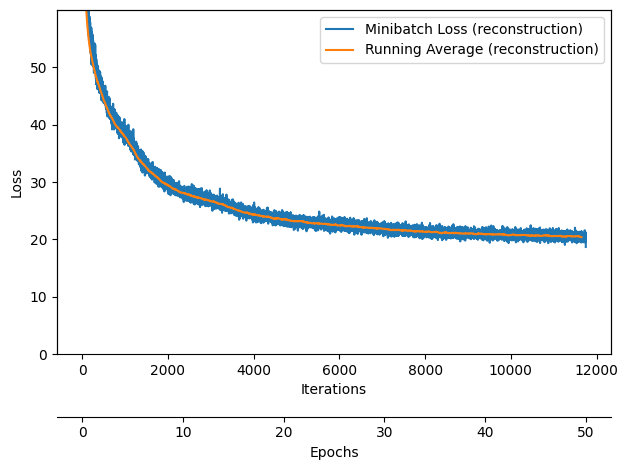

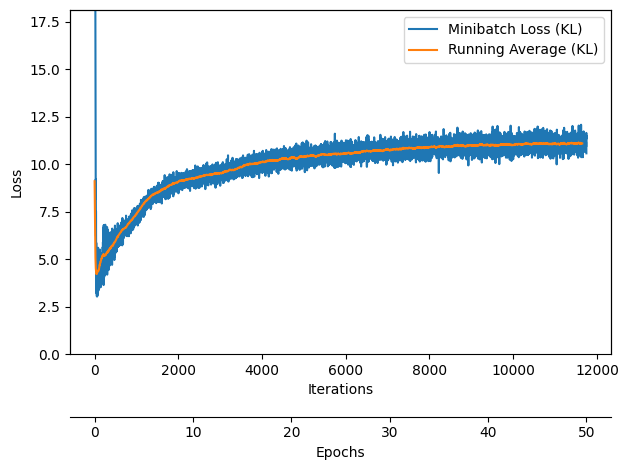

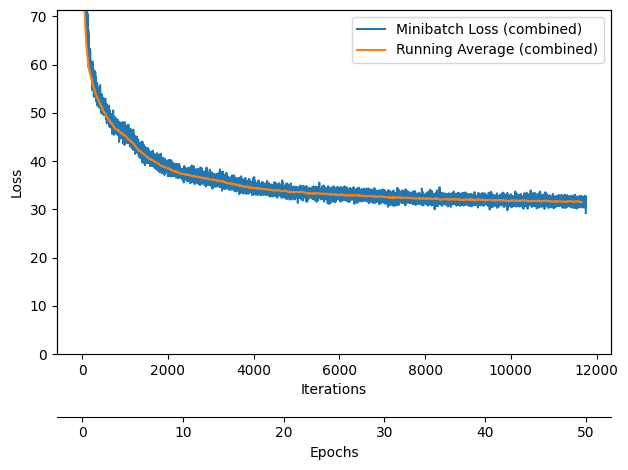

In [34]:
plot_training_loss(history_256d['train_reconstruction_loss_per_batch'], EPOCHS, custom_label=" (reconstruction)")
plot_training_loss(history_256d['train_kl_loss_per_batch'], EPOCHS, custom_label=" (KL)")
plot_training_loss(history_256d['train_combined_loss_per_batch'], EPOCHS, custom_label=" (combined)")
plt.show()

VAE with latent dimensions = 256 demonstrates similar convergence pattern to the VAE with latent dimensions = 128, with the Reconstruction Loss stabilizing around the same value. This indicates that increasing latent capacity did not improve the model's expressive power regarding image reconstruction quality. Both the Reconstruction Loss and KL Divergence Loss stabilize at the same point, suggesting that the original D=128 space waas probably sufficient to capture the necessary information.

In [ ]:
# Load model from file

#weights_path = os.path.join(SAVE_DIR, f"vae_weights_epoch_{EPOCHS}.pth")
#trained_model_256 = VAE(latent_dims=LATENT_DIM).to(DEVICE)
#trained_model_256.load_state_dict(torch.load(weights_path, map_location=DEVICE))

<All keys matched successfully>


 Reconstruction Quality (D=256)


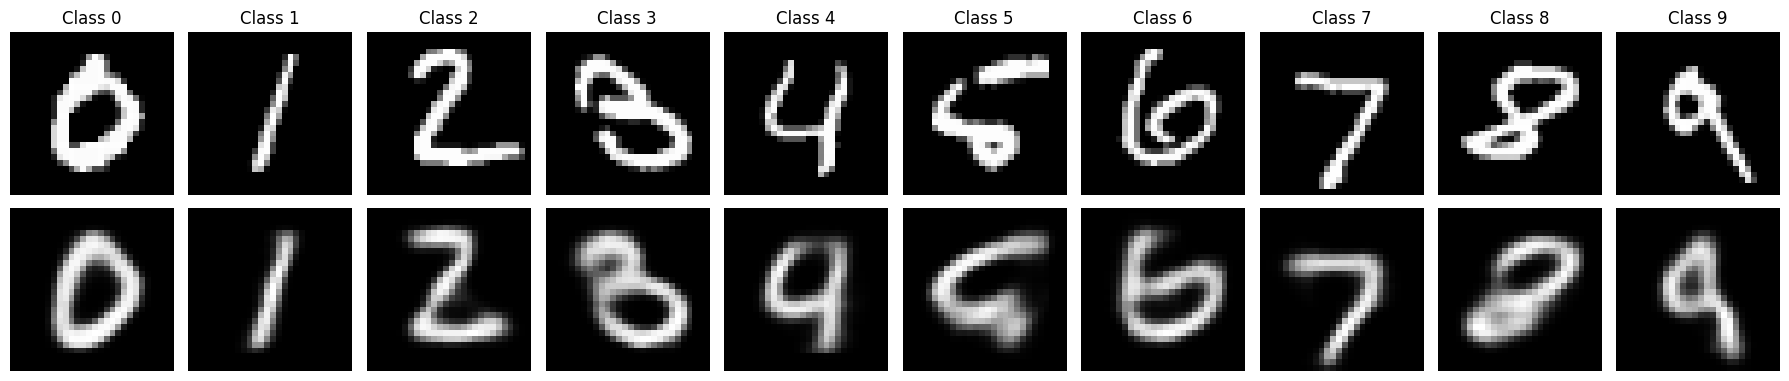


 Latent Space Evolution (D=256)

Generating t-SNE evolution for epochs: [1, 10, 30, 50]...


Processing t-SNE snapshots: 100%|██████████| 4/4 [01:05<00:00, 16.46s/it]


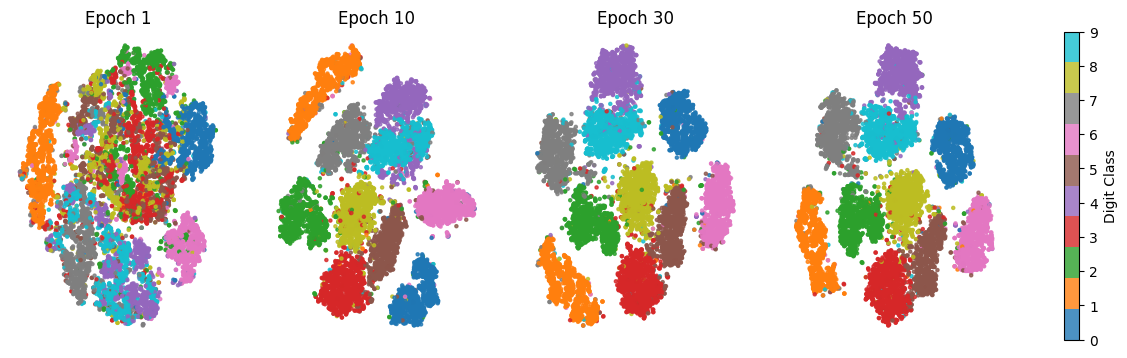


 Generated Samples (D=256)


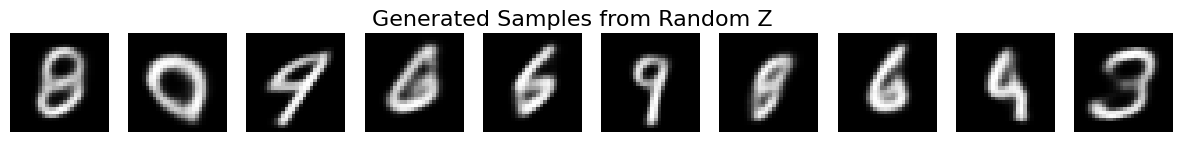


 Latent Space Interpolation (D=256)


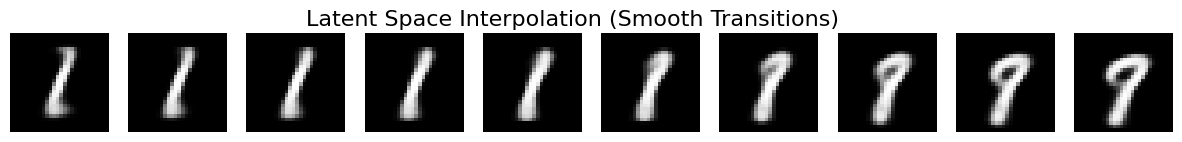

In [37]:

print("\n Reconstruction Quality (D=256)")
visualize_reconstruction(trained_model_256, test_loader, DEVICE)
print("\n Latent Space Evolution (D=256)")
visualize_latent_structure_evolution(VAE, LATENT_DIM, test_loader, DEVICE, [1, 10, 30, 50], weights_dir=SAVE_DIR)
print("\n Generated Samples (D=256)")
generate_samples(trained_model_256, LATENT_DIM, DEVICE)
print("\n Latent Space Interpolation (D=256)")
interpolate_samples(trained_model_256, LATENT_DIM, DEVICE)

### Results for latent dimensions = 256:
* **Reconstruction quality:**    
The reconstruction for each class looks good. However some reconstruction images are very blurred.  

* **Laten Space evolution:**     
Again, the model performed significant improvement over the initial epochs (1-10). After first 10 epochs, model did some visible improvement, but it was not that spectacular. After 50 epochs, most of the classes are nicely separated and clustered.

* **Generated samples from Random Z vectors:**    
Most images  resemble digits. For me images number 4 and 7 are unclassicable.  

* **Latent Space interpolation:**     
The process shows continuous transition from the features of '1' to '9'. However, the generated images at both extremes, especially the initial 1 digit, do not represent perfect and clear samples of their classes.

## Comaprison of latent dimensionality (128 vs 256):
* **Loss curves**:     
Both models show similar convergence trends — fast initial improvement followed by gradual stabilization.
The lack of significant difference between the 128 and 256 latent dimensions implies that increasing latent dimensionality beyond a certain point does not necessarily enhance model performance, especially for relatively simple datasets like MNIST.
* **Reconstruction quality**:     
Both models achieve very good reconstruction quality — the decoded images are visually close to the originals.
* **Latent Space evolution**:     
In both cases, the latent space becomes more organized over the first 10 epochs, after which improvements slow down.    
* **Generation from Random Z Vectors**: 
The 128-dimensional model’s generated images doesn't resemble original digits. The images are confusing, and they very often show mixture of two digits.  The 256-dimensional model produced more realistic digits. 
* **Latent Space Interpolation**:     
Both models showed smooth and continuous transition between two digits.

The overall conclusion highlights a subtle difference in the models' ability to structure the data, rather than their ability to reconstruct it.

The total training losses showed minimal difference between the D=128 and D=256 models, with both achieving the same minimum Reconstruction Loss. This strongly confirms that D=128 had sufficient capacity to encode all essential information for the simple MNIST dataset.

However, the key difference occurred in the Generation from Random Z Vector Analysis. The D=128 model failed to create recognizable digits. This proves that the increased dimensionality can help to improve the organization and continuity of the latent space. 